In [1]:
library(rptR)
library(ggplot2)
library(lindia)
library(tidyverse)
library(lmerTest) #lmer, glmer
library(DHARMa) #verify assumption of glm
#a residual of 0 means that 0% of the simulated values are smaller than the observed value
library(merTools) #sim
#library(glmmADMB)
library(glmmTMB) #much faster than glmmADMB
library(lme4)
library(MASS)
library(boot) #bootstrap

Warning message:
"package 'rptR' was built under R version 3.6.3"
Warning message:
"package 'lindia' was built under R version 3.6.3"
Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'stringr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts --------------------------------------------------------

# Define parameters

In [2]:
#should be consistent across all notebooks
#ADD YOUR PATH TO SAVE OUTPUT AND WEHRE THE INITIALL EXCEL ARE
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'

# Download data

In [3]:
df = read.csv(file.path(path_,'OFH_df_MVT_ALLVAR'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID)
df$level = as.factor(df$level) 
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)

#setting reference group
contrasts(df$Treatment)
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)
contrasts(df$CLASS)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "REXP"))
contrasts(df$CLASS)
print(dim(df))
summary(df)

#make sure its integer and not TRUE/FALSE
df$WentinWG = as.integer(df$WentinWG)
df$Sleeping_Uppest = as.integer(df$Sleeping_Uppest)

#intitialising subset dataframe for repeatability over time, across and within context
df_selOFH = df[df$Treatment=='OFH',]
dim(df_selOFH)

df_selTRAN = df[df$Treatment=='TRAN',]
dim(df_selTRAN)

,TRAN
OFH,0
TRAN,1


,OFH
TRAN,0
OFH,1


,MEXP,REXP
LEXP,0,0
MEXP,1,0
REXP,0,1


,LEXP,MEXP
REXP,0,0
LEXP,1,0
MEXP,0,1


[1] 4578   25


     HenID          PenID             level      Treatment    CLASS     
 hen_10 :  30   pen5   : 600   2021-01-16: 159   TRAN:2253   REXP:2661  
 hen_101:  30   pen10  : 589   2021-01-09: 158   OFH :2325   LEXP: 863  
 hen_102:  30   pen11  : 588   2021-01-23: 158               MEXP:1054  
 hen_107:  30   pen4   : 579   2021-02-06: 158                          
 hen_109:  30   pen3   : 571   2021-04-17: 158                          
 hen_112:  30   pen9   : 566   2020-11-28: 157                          
 (Other):4398   (Other):1085   (Other)   :3630                          
      DOA             WOA             DIB             WIB        weight_interp 
 Min.   :178.0   Min.   :26.00   Min.   : 60.0   Min.   : 9.00   Min.   :1245  
 1st Qu.:227.0   1st Qu.:33.00   1st Qu.:109.0   1st Qu.:16.00   1st Qu.:1724  
 Median :283.0   Median :41.00   Median :165.0   Median :24.00   Median :1821  
 Mean   :288.7   Mean   :41.82   Mean   :170.7   Mean   :24.82   Mean   :1828  
 3rd Qu.:346.0  

[1] 2325   25

[1] 2253   25

In [4]:
#initialize the number of boostrap replicates 
nboot_ = 100
nbr_replicate = 100

# Define Functions

In [5]:
####### a fct to get repeatability for gamma distribution with CI

#### boostrapping ####
#R: nbr of bootstrap replicates.
#statistic: fct should include an indices parameter that the boot() function can use to select cases for each replication
#boot( ) calls the statistic function R times & each time it generates a set of random indices, with replacement, from the 
#integers 1:nrow(data). These indices are used within the statistic function to select a sample. 
#we can add the parameters that has to be passed to the function that produces the statistic of interest, in this case: formula

#### repeatability ####
#as in the Nakagawa paper, except changing how to get things from glmmadm to glmmTMB:
#althought the new 2017 rpt T paper suggest and illustrate the use of glmmadmb, because of:
#https://github.com/florianhartig/DHARMa/issues/19  &  https://github.com/bbolker/glmmadmb/issues/12 ,
#we should use glmmTMB, which is much much faster to run than the glmmadmb
#Note: glmmTMB warnings are fine and can be ignored (https://github.com/glmmTMB/glmmTMB/issues/615)
#Nun: from: http://cran.nexr.com/web/packages/glmmTMB/glmmTMB.pdf: "Internally, glmmTMB fits Gamma responses by fitting a mean and 
#a shape parameter; sigma is estimated as (1/sqrt(shape))..." so in glmmadmb the shape parameter (nuF) = 1/sigma^2 
#in glmmamb the shape parameter is written in the output as being equal to the modF$alpha 
ICC_R_squared = function(formula_str, main_var, data, indices) {
    #selecting sample with boot
    data_boot = data[indices,] 
    
    # Fit null model without fixed effects (but including all random effects)
    modR = glmmTMB(as.formula(paste(main_var, " ~ 1 + (1|HenID)")), family = Gamma(link = "log"), data=data_boot)
    # Fit alternative model including fixed and all random effects
    modF = glmmTMB(as.formula(paste(main_var, formula_str)), family=Gamma(link="log"), data=data_boot)

    #calculation of the variance in fitted values
    VarF = var(as.vector(model.matrix(modF)[[1]] %*%fixef(modF)[[1]]))

    #getting the observation-level variance Null model (the shape parameter)
    nuN = 1/summary(modR)$sigma^2 #1/summary(modR)$sigma^2 instead of modR$alpha in glmmadmb 
    VarOdN = 1/nuN # the delta method
    VarOlN = log(1 + 1/nuN)# log-normal approximation
    VarOtN = trigamma(nuN)# trigamma function

    #full model: nuF is the shape parameter by Nakagawa papers definition
    nuF = 1/summary(modF)$sigma^2 #instead of  modF$alpha, in glmmadmb 
    VarOdF = 1/nuF# the delta method
    VarOlF = log(1 + 1/nuF)# log-normal approximation
    VarOtF = trigamma(nuF)# trigamma function

    #marginal R2
    R2glmmM = VarF/(VarF +sum(as.numeric(VarCorr(modF)[[1]])) + VarOtF)
    #conditional R2 for full model
    R2glmmC = (VarF +sum(as.numeric(VarCorr(modF)[[1]])))/(VarF +sum(as.numeric(VarCorr(modF)[[1]])) +VarOtF)
    #raw unadjusted R
    ICCrawPop = VarCorr(modR)[[1]]$HenID[1]/(sum(as.numeric(VarCorr(modR)[[1]])) +VarOtN)
    #adjusted R
    VI = VarCorr(modF)[[1]]$HenID[1] #note that in our case as we only have HenID: VI = sum(as.numeric(VarCorr(modF)[[1]]))
    VE = VarOtF #NOTE: in gamma the VE (observation level  variance) is defined by : trigamma(shape)
    ICCadjPop = VI/(VI +VE)
    m_ = exp(fixef(modF)[[1]][['(Intercept)']]) #due to log link  
    return (c(R2glmmM, R2glmmC, ICCrawPop, ICCadjPop, VI, VE, m_, sqrt(VI/m_), sqrt(VE/m_)))
} 

In [6]:
########### fct to get additional output (mean, cv etc)
further_res = function(model_, cv=TRUE) {
    #selecting sample with boot
    set.seed(1234)
    print(VarCorr(model_),comp =c("Variance","Std.Dev."))
    VI = VarCorr(model_)$"HenID"[1]
    VE = attr(VarCorr(model_), "sc")^2
    rep = VI/(VI+VE) # sd^2 = equal to the variance of residual
    m_ = fixef(model_)[['(Intercept)']]    
    #with posterior distribution with 1000 simulations and credible interval
    simulated = sim(model_, n.sim = 1000)
    posterior_HenID = apply(simulated@ranef$"HenID"[ , , 1],1,var) #,1,: rows ; 2, column
    posterior_residual  = simulated@sigma^2
    #check repeatatbility althought reported with rpt
    print(rep)
    print(quantile(posterior_HenID/(posterior_HenID+posterior_residual), prob=c(0.025, 0.5, 0.975)))
    
    posterior_mvtmean = simulated@fixef[,'(Intercept)']
    VI_t = paste0(as.character(round(VI,4)),' [',
                   as.character(round(quantile(posterior_HenID, prob=c(0.025, 0.5, 0.975))[["2.5%"]],4)), ', ',
                   as.character(round(quantile(posterior_HenID, prob=c(0.025, 0.5, 0.975))[["97.5%"]],4)), ']')
    VE_t = paste0(as.character(round(VE,4)),' [',
                   as.character(round(quantile(posterior_residual, prob=c(0.025, 0.5, 0.975))[["2.5%"]],4)), ', ',
                   as.character(round(quantile(posterior_residual, prob=c(0.025, 0.5, 0.975))[["97.5%"]],4)), ']')
    popintercept_t = paste0(as.character(round(m_,4)),' [',
                   as.character(round(quantile(posterior_mvtmean, prob=c(0.025, 0.5, 0.975))[["2.5%"]],4)), ', ',
                   as.character(round(quantile(posterior_mvtmean, prob=c(0.025, 0.5, 0.975))[["97.5%"]],4)), ']')
    CVI_t = NULL
    CVE_t = NULL
    if (cv==TRUE){
        CVI_t = paste0(as.character(round(sqrt(VI/m_),4)),' [',
                       as.character(round(quantile(sqrt(posterior_HenID/posterior_mvtmean), prob=c(0.025, 0.5, 0.975))[["2.5%"]],4)), ', ',
                       as.character(round(quantile(sqrt(posterior_HenID/posterior_mvtmean), prob=c(0.025, 0.5, 0.975))[["97.5%"]],4)), ']')
        CVE_t = paste0(as.character(round(sqrt(VE/m_),4)),' [',
                       as.character(round(quantile(sqrt(posterior_residual/posterior_mvtmean), prob=c(0.025, 0.5, 0.975))[["2.5%"]],4)), ', ',
                       as.character(round(quantile(sqrt(posterior_residual/posterior_mvtmean), prob=c(0.025, 0.5, 0.975))[["97.5%"]],4)), ']')
        }
    return (c(VI_t, VE_t, popintercept_t, CVI_t, CVE_t))
} 

In [7]:
#output more from the bootstrapping
further_res_fromboot = function(output) {
    df_Routput = data.frame(output$t)
    VI = colMeans(df_Routput)[[5]]
    CI_ = boot.ci(output, type=c("norm","basic","perc"), index=5)
    L = round(CI_$perc[[4]],4)
    U = round(CI_$perc[[5]],4)
    VI_t = paste0(as.character(round(VI,4)),' [', as.character(L), ', ', as.character(U), ']')

    VE = colMeans(df_Routput)[[6]]
    CI_ = boot.ci(output, type=c("norm","basic","perc"), index=6)
    L = round(CI_$perc[[4]],4)
    U = round(CI_$perc[[5]],4)
    VE_t = paste0(as.character(round(VE,4)),' [', as.character(L), ', ', as.character(U), ']')

    m_ = colMeans(df_Routput)[[7]]
    CI_ = boot.ci(output, type=c("norm","basic","perc"), index=7)
    L = round(CI_$perc[[4]],4)
    U = round(CI_$perc[[5]],4)
    popintercept_t = paste0(as.character(round(m_,4)),' [', as.character(L), ', ', as.character(U), ']')

    CVI = colMeans(df_Routput)[[8]]
    CI_ = boot.ci(output, type=c("norm","basic","perc"), index=8)
    L = round(CI_$perc[[4]],4)
    U = round(CI_$perc[[5]],4)
    CVI_t = paste0(as.character(round(CVI,4)),' [', as.character(L), ', ', as.character(U), ']')

    CVE = colMeans(df_Routput)[[9]]
    CI_ = boot.ci(output, type=c("norm","basic","perc"), index=9)
    L = round(CI_$perc[[4]],4)
    U = round(CI_$perc[[5]],4)
    CVE_t = paste0(as.character(round(CVE,4)),' [', as.character(L), ', ', as.character(U), ']')
    
    return (c(VI_t, VE_t, popintercept_t, CVI_t, CVE_t))
}

# 1. Sleeping_Uppest

In [28]:
#initialise list to save results
li_R = c()
li_CIL = c()
li_CIU = c()
li_ngroup = c()
li_nobs = c()
li_BStype = c()
li_mvt = c()
li_mvtmean = c()
li_VI = c()
li_VE = c()

Bootstrap Progress:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.517
SE = 0.054
CI = [0.373, 0.567]
P  = 6.38e-187 [LRT]
     NA [Permutation]

Original-scale approximation:
R  = 0.963
SE = 0.188
CI = [0.52, 1.2]
P  = 6.38e-187 [LRT]
     NA [Permutation]


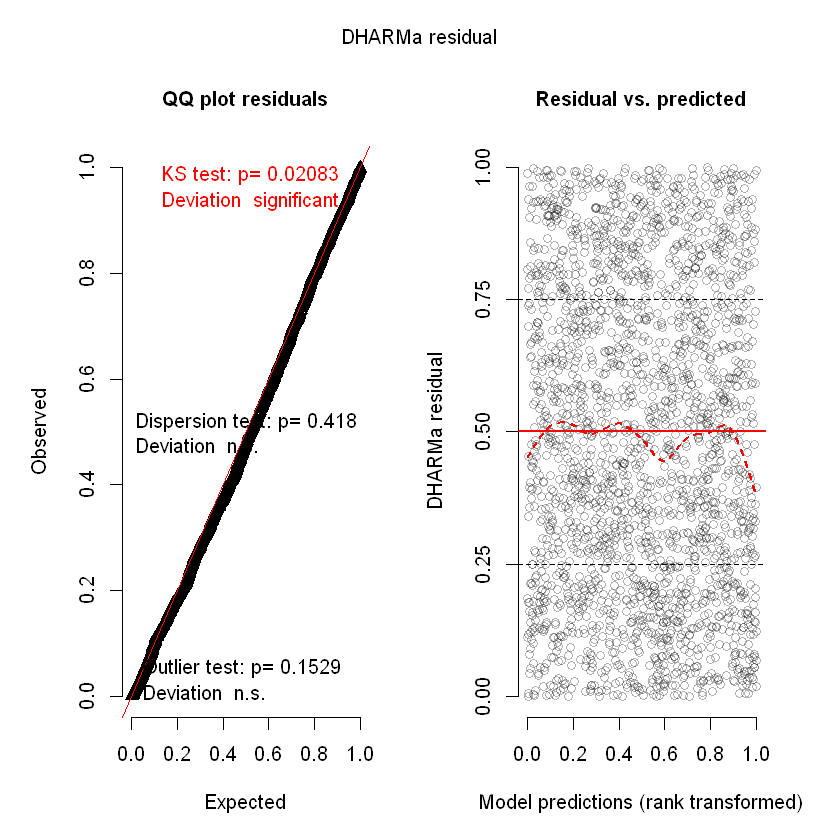

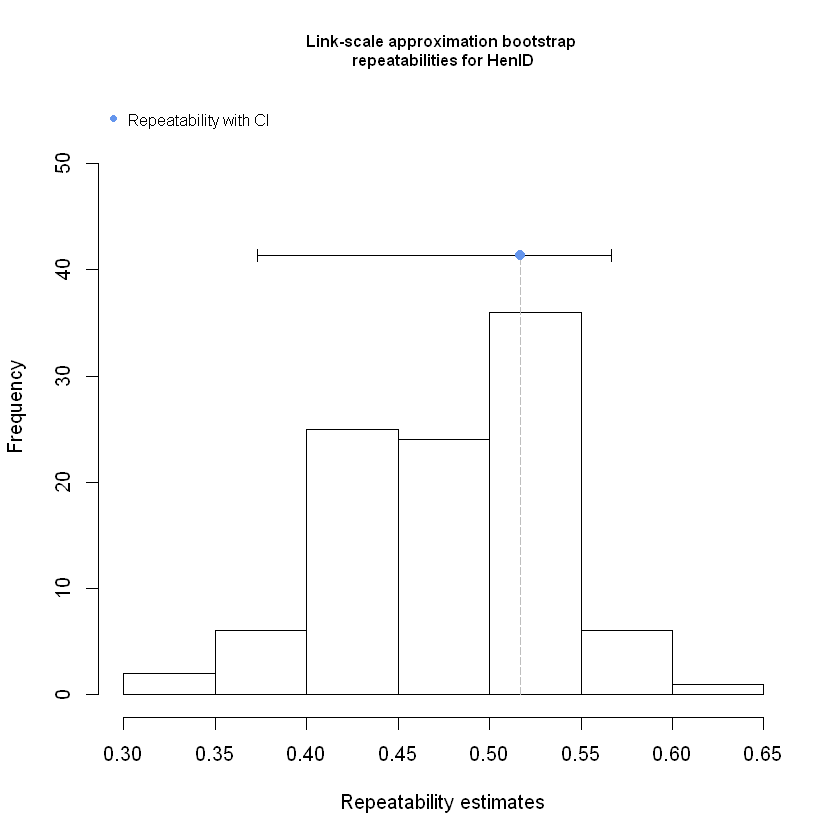

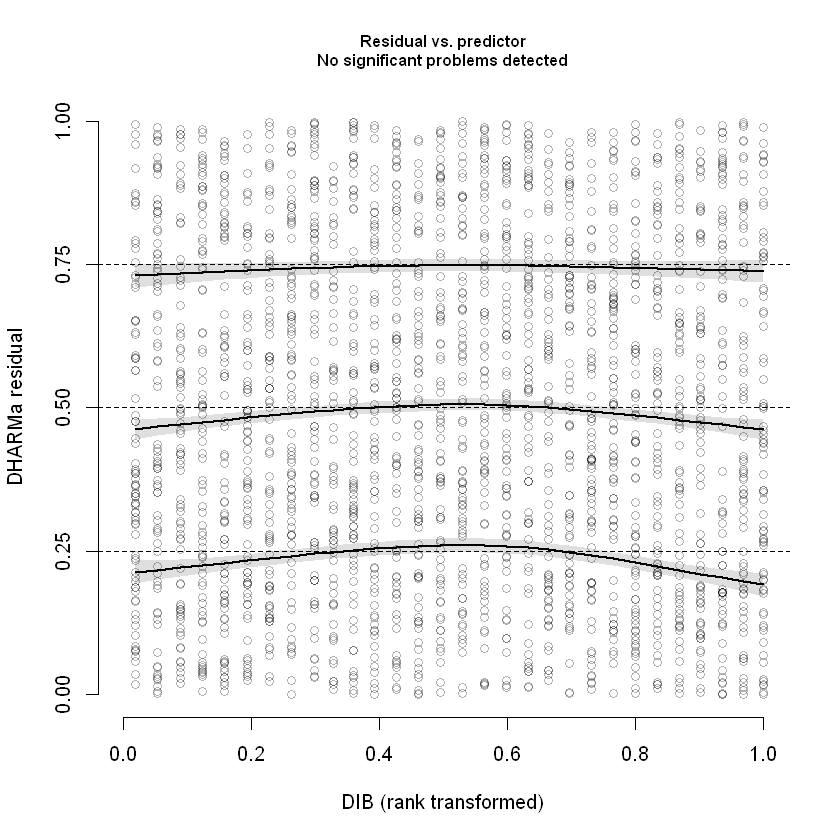

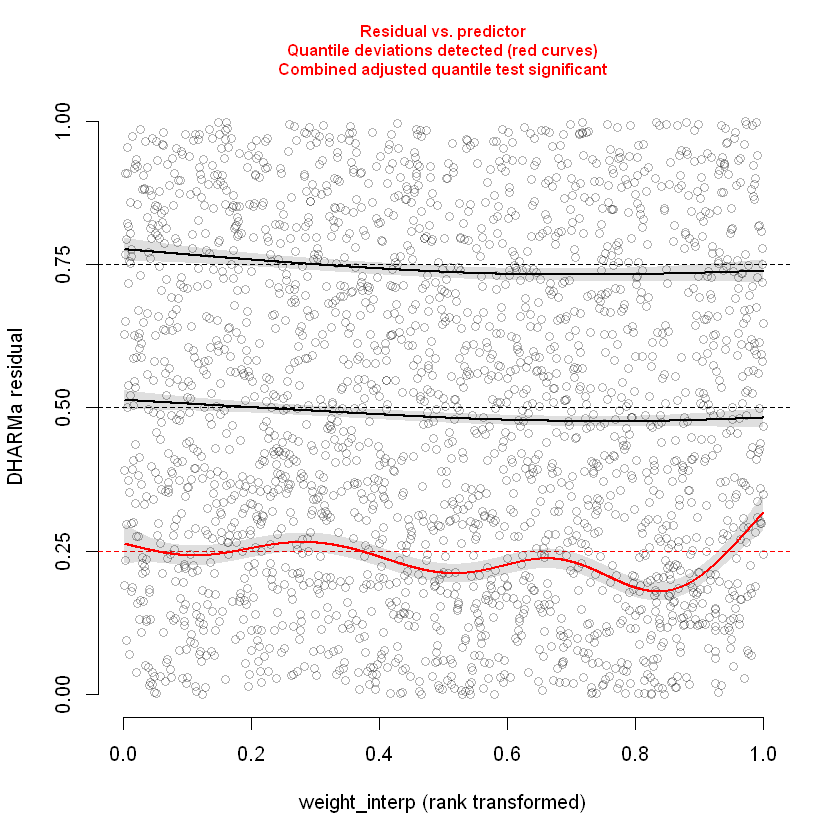


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 1.052, p-value = 0.418
alternative hypothesis: two.sided


Bootstrap Progress:




Variance estimation using the glmm method and logit link 

Variance of HenID
--------------------------------
Link-scale approximation:
Var = 5.109
SE = 1.108
CI = [3.109, 7.084]
P  = 6.38e-187 [LRT]
     NA [Permutation]

Variance of Residual
--------------------------------
Link-scale approximation:
Var = 4.772
SE = 0.33
CI = [4.522, 5.761]
P  = NA [LRT]
     NA [Permutation]


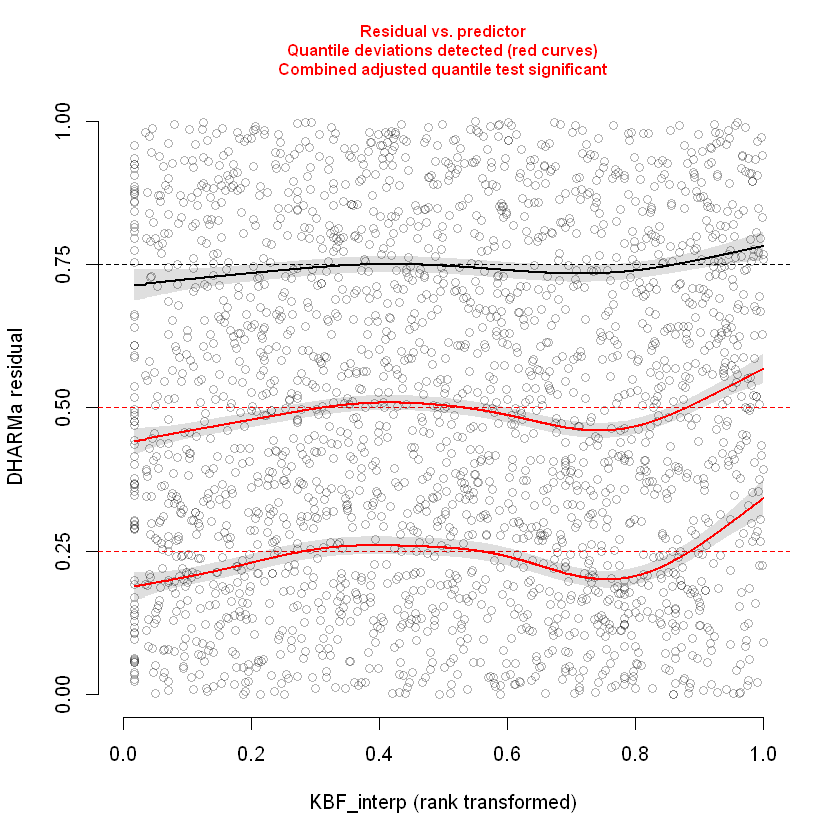

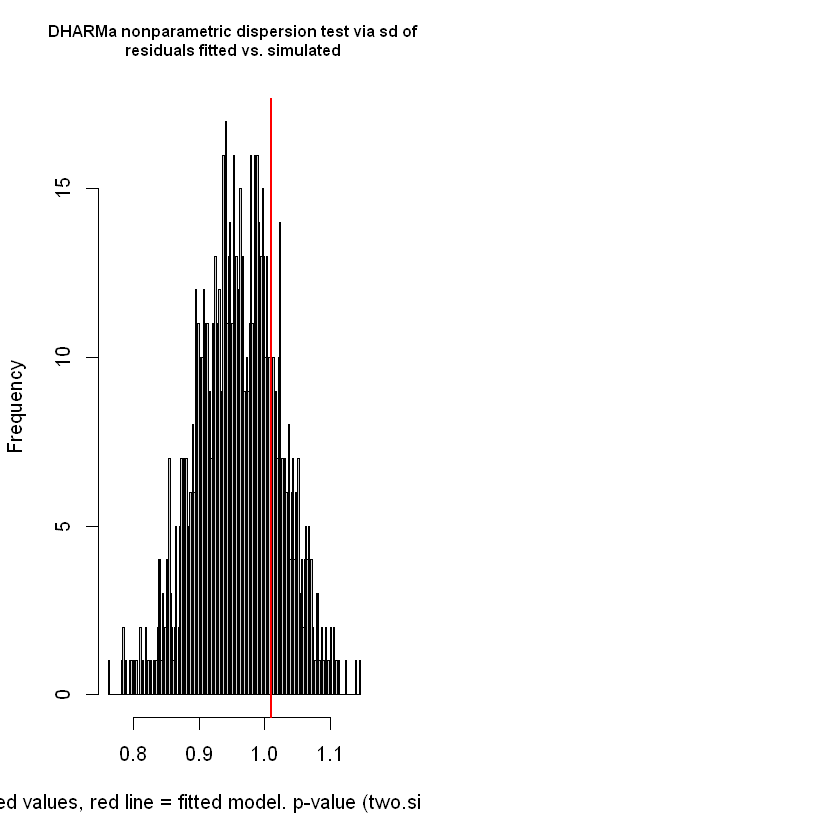

In [29]:
#LP2 
set.seed(1234)
mod_ = rpt(Sleeping_Uppest ~ scale(weight_interp)+scale(DIB)+ scale(KBF_interp) +CLASS+ (1|HenID),
               grname=c("HenID"), datatype = "Binary", data=df_selOFH, adjusted =TRUE, nboot = nboot_, npermut = 0) 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)
plot(mod_, grname = "HenID", type = "boot", cex.main = 0.8)
plotResiduals(sim_res, df_selOFH$DIB, quantreg = T)
plotResiduals(sim_res, df_selOFH$weight_interp, quantreg = T)
plotResiduals(sim_res, df_selOFH$KBF_interp, quantreg = T)
par(mfrow = c(1,2))
testDispersion(sim_res)

#save results
li_R = append(li_R, mod_$R[[1]][2]) #2: link scale
li_CIL = append(li_CIL, mod_$CI_emp$CI_link[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp$CI_link[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'OFH')
li_mvt = append(li_mvt, 'Sleeping_Uppest')
li_mvtmean = append(li_mvtmean, mean(df_selOFH$Sleeping_Uppest))

#add VI,VE
mod_ = rpt(Sleeping_Uppest ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp) +CLASS+ (1|HenID),
               grname=c("HenID",'Residual'), datatype="Binary", data=df_selOFH, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit', ratio=FALSE)  # shouldnt be here: 'Overdispersion'
mod_
VI = round(mod_$R['R_link','HenID'], 4) #henid var
VI_L = round(mod_$CI_emp$CI_link['HenID','2.5%'], 4)
VI_U = round(mod_$CI_emp$CI_link['HenID','97.5%'], 4)
VE = round(mod_$R['R_link','Residual'], 4) #residual var
VE_L = round(mod_$CI_emp$CI_link['Residual','2.5%'], 4)
VE_U = round(mod_$CI_emp$CI_link['Residual','97.5%'], 4)
li_VI = append(li_VI,paste0(as.character(VI),' [', as.character(VI_L), ', ', as.character(VI_U), ']')) 
li_VE = append(li_VE, paste0(as.character(VE),' [', as.character(VE_L), ', ', as.character(VE_U), ']'))

Bootstrap Progress:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.452
SE = 0.042
CI = [0.334, 0.489]
P  = 1.78e-134 [LRT]
     NA [Permutation]

Original-scale approximation:
R  = 0.652
SE = 0.1
CI = [0.401, 0.772]
P  = 1.78e-134 [LRT]
     NA [Permutation]


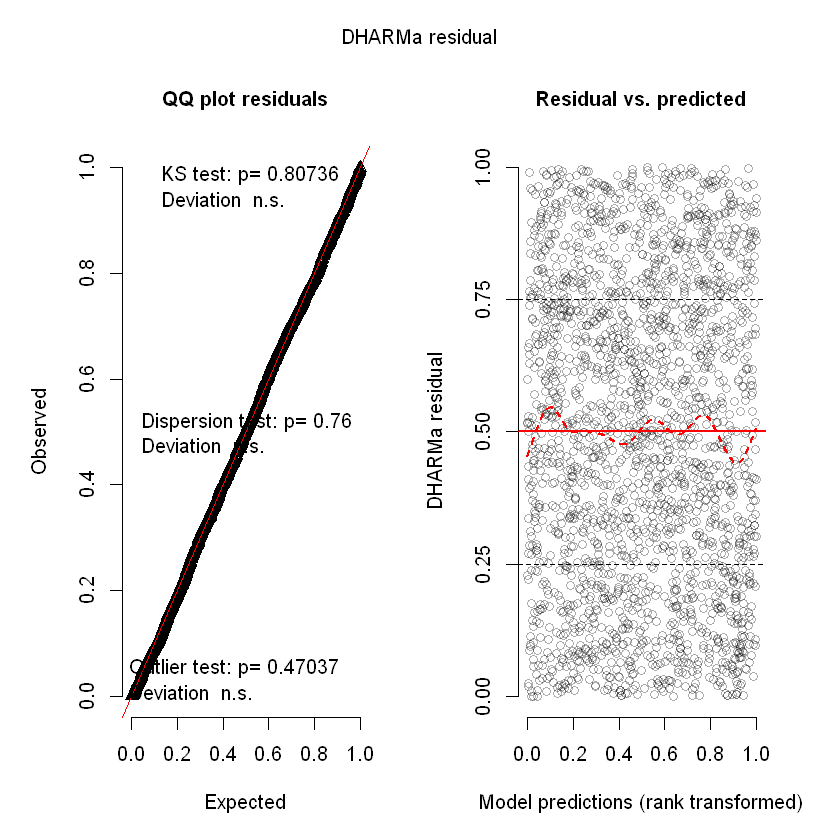

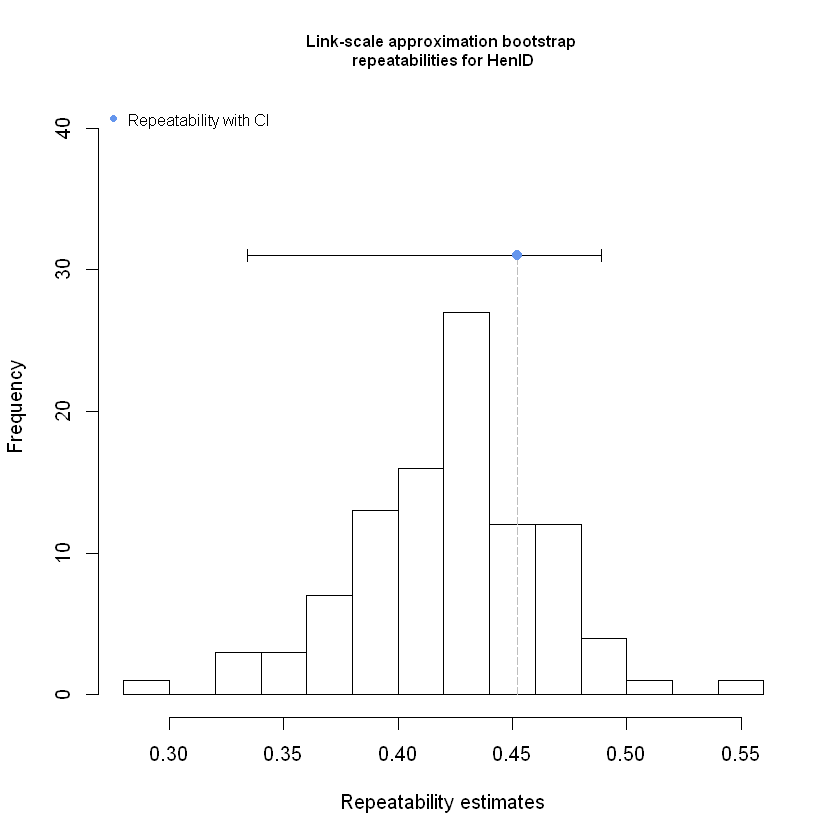

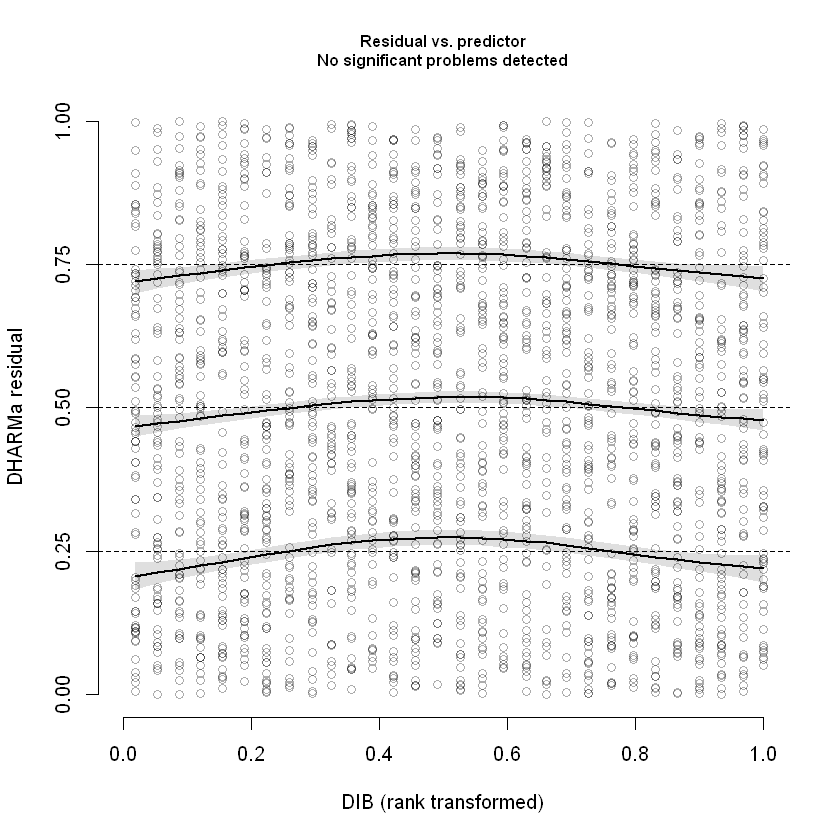

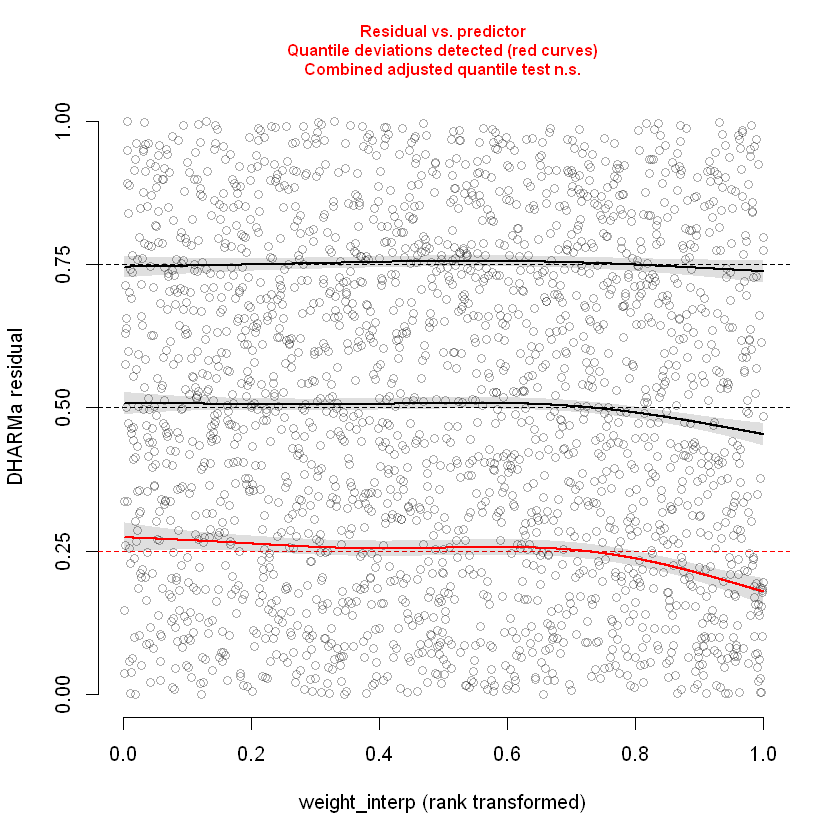


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 1.0201, p-value = 0.76
alternative hypothesis: two.sided


Bootstrap Progress:




Variance estimation using the glmm method and logit link 

Variance of HenID
--------------------------------
Link-scale approximation:
Var = 3.749
SE = 0.737
CI = [2.287, 5.051]
P  = 1.78e-134 [LRT]
     NA [Permutation]

Variance of Residual
--------------------------------
Link-scale approximation:
Var = 4.543
SE = 0.238
CI = [4.237, 5.079]
P  = NA [LRT]
     NA [Permutation]


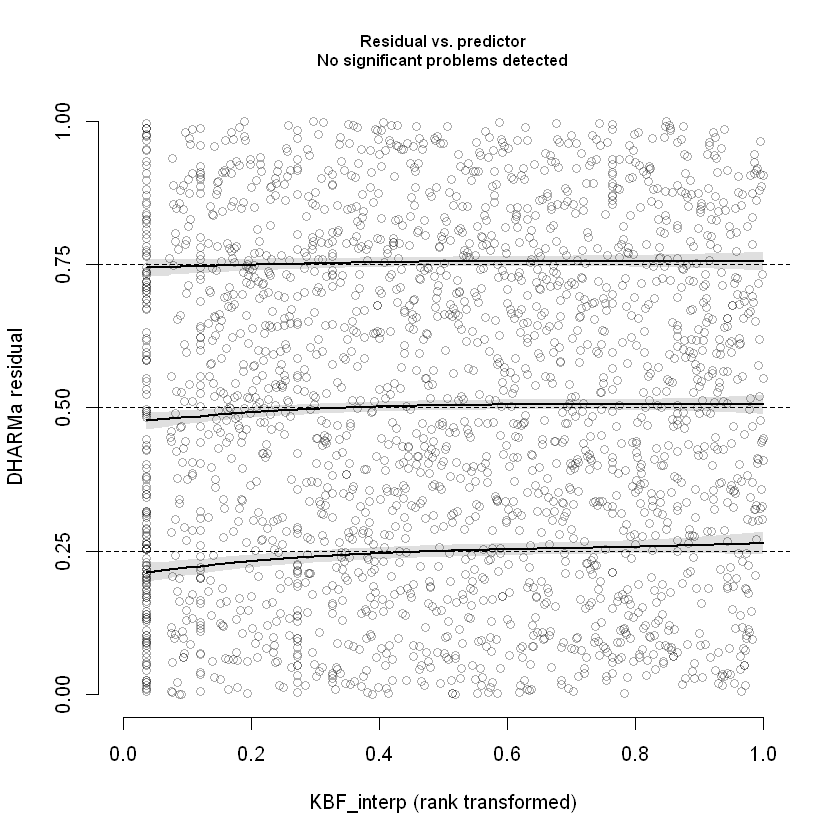

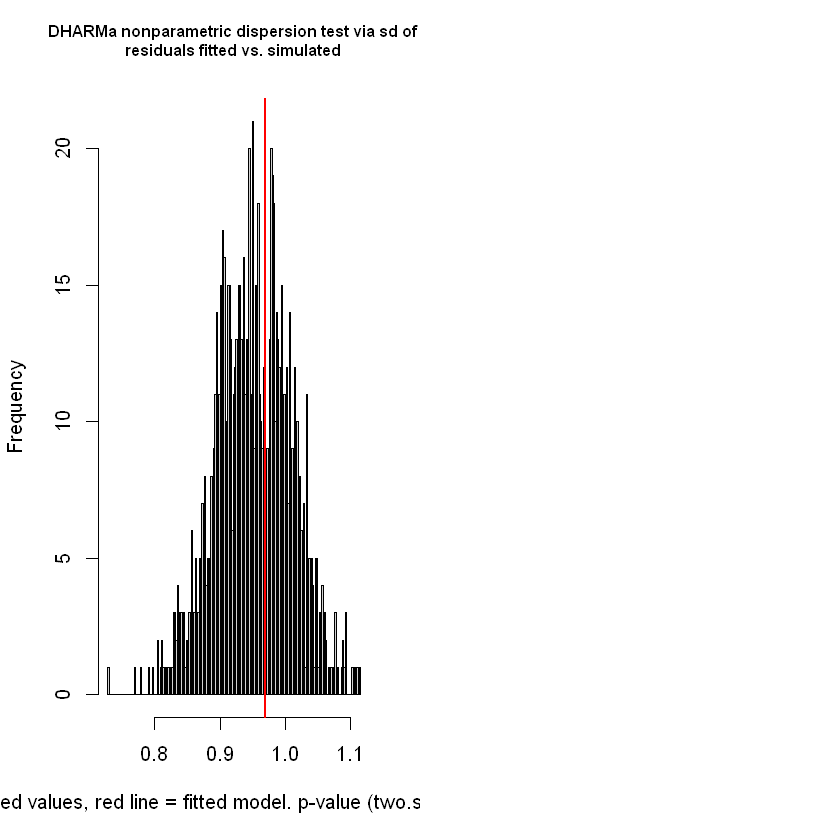

In [30]:
#LP10
set.seed(1234)
mod_ = rpt(Sleeping_Uppest ~ scale(weight_interp)+scale(DIB)+scale(KBF_interp) +CLASS+ (1|HenID),
               grname=c("HenID"), datatype = "Binary", data=df_selTRAN, adjusted =TRUE, nboot = nboot_, npermut = 0) 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)
plot(mod_, grname = "HenID", type = "boot", cex.main = 0.8)
plotResiduals(sim_res, df_selTRAN$DIB, quantreg = T)
plotResiduals(sim_res, df_selTRAN$weight_interp, quantreg = T)
plotResiduals(sim_res, df_selTRAN$KBF_interp, quantreg = T)
par(mfrow = c(1,2))
testDispersion(sim_res)

#save results
li_R = append(li_R, mod_$R[[1]][2]) #2: link scale
li_CIL = append(li_CIL, mod_$CI_emp$CI_link[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp$CI_link[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'TRAN')
li_mvt = append(li_mvt, 'Sleeping_Uppest')
li_mvtmean = append(li_mvtmean, mean(df_selTRAN$Sleeping_Uppest))

#add VI,VE
mod_ = rpt(Sleeping_Uppest ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp) +CLASS+ (1|HenID),
               grname=c("HenID",'Residual'), datatype="Binary", data=df_selTRAN, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit', ratio=FALSE)  # shouldnt be here: 'Overdispersion'
mod_
VI = round(mod_$R['R_link','HenID'], 4) #henid var
VI_L = round(mod_$CI_emp$CI_link['HenID','2.5%'], 4)
VI_U = round(mod_$CI_emp$CI_link['HenID','97.5%'], 4)
VE = round(mod_$R['R_link','Residual'], 4) #residual var
VE_L = round(mod_$CI_emp$CI_link['Residual','2.5%'], 4)
VE_U = round(mod_$CI_emp$CI_link['Residual','97.5%'], 4)
li_VI = append(li_VI,paste0(as.character(VI),' [', as.character(VI_L), ', ', as.character(VI_U), ']')) 
li_VE = append(li_VE, paste0(as.character(VE),' [', as.character(VE_L), ', ', as.character(VE_U), ']'))

In [31]:
#save results
df_res = data.frame(li_R, li_CIL, li_CIU, li_ngroup, li_nobs, li_BStype, li_mvt, li_mvtmean,
                   li_VI, li_VE)
write.csv(df_res, file.path(path_ ,'OFH_R_estimates_SNU.csv'))
df_res

li_R,li_CIL,li_CIU,li_ngroup,li_nobs,li_BStype,li_mvt,li_mvtmean,li_VI,li_VE
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<fct>
0.5170527,0.3731341,0.5665778,96,2325,OFH,Sleeping_Uppest,0.7010753,"5.1087 [3.1093, 7.0841]","4.7717 [4.5218, 5.7611]"
0.4521158,0.3339564,0.4888976,98,2253,TRAN,Sleeping_Uppest,0.6728806,"3.749 [2.2867, 5.0512]","4.5431 [4.2371, 5.0786]"


# 2. Food reactivity index

In [12]:
#initialise list to save results
li_R = c()
li_CIL = c()
li_CIU = c()
li_ngroup = c()
li_nobs = c()
li_BStype = c()
li_mvt = c()
li_mvtmean = c()
li_VI = c()
li_VE = c()
li_popintercept = c()
li_CVI = c()
li_CVE = c()

Bootstrap Progress:


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.293
SE = 0.03
CI = [0.231, 0.354]
P  = 1.38e-117 [LRT]
     NA [Permutation]



Linear mixed model fit by REML ['lmerMod']
Formula: 
food_sameDurTiming_r50_final ~ scale(weight_interp) + scale(KBF_interp) +  
    scale(DIB) + CLASS + (1 | HenID)
   Data: data

REML criterion at convergence: 267.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9581 -0.6179  0.0794  0.6912  3.0222 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.02434  0.1560  
 Residual             0.05880  0.2425  
Number of obs: 2325, groups:  HenID, 96

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           0.208781   0.021258   9.821
scale(weight_interp) -0.030146   0.012328  -2.445
scale(KBF_interp)    -0.010502   0.009779  -1.074
scale(DIB)            0.031092   0.008556   3.634
CLASSLEXP            -0.018218   0.044788  -0.407
CLASSMEXP             0.048293   0.043787   1.103

Correlation of Fixed Effects:
            (Intr) scl(_) s(KBF_ s(DIB) CLASSL
scl(wght_n)  0.016                            
scl(KBF_nt) 

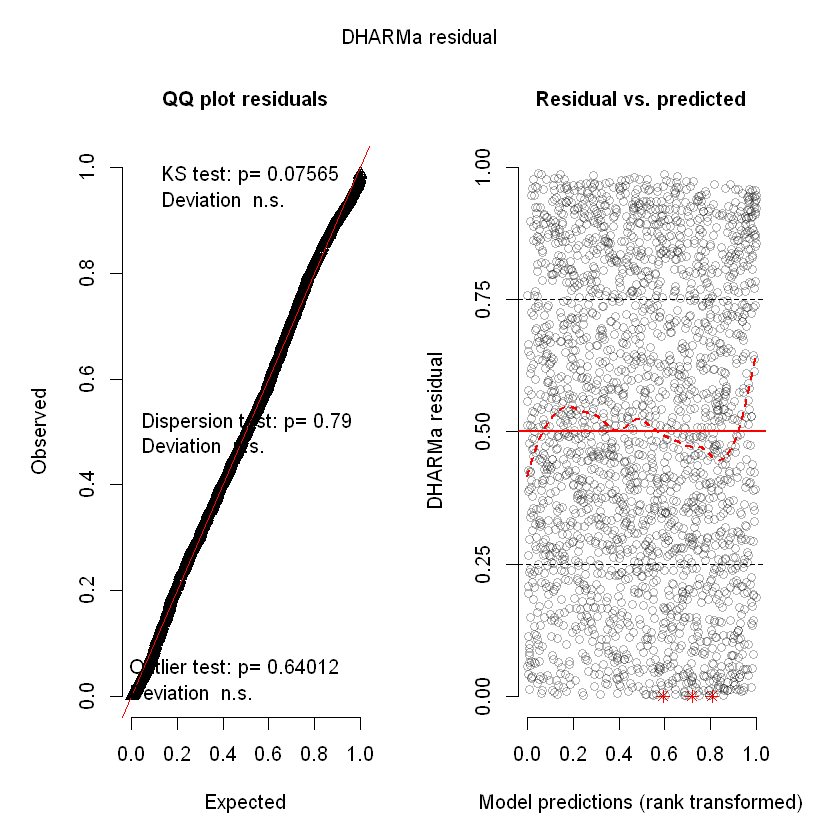

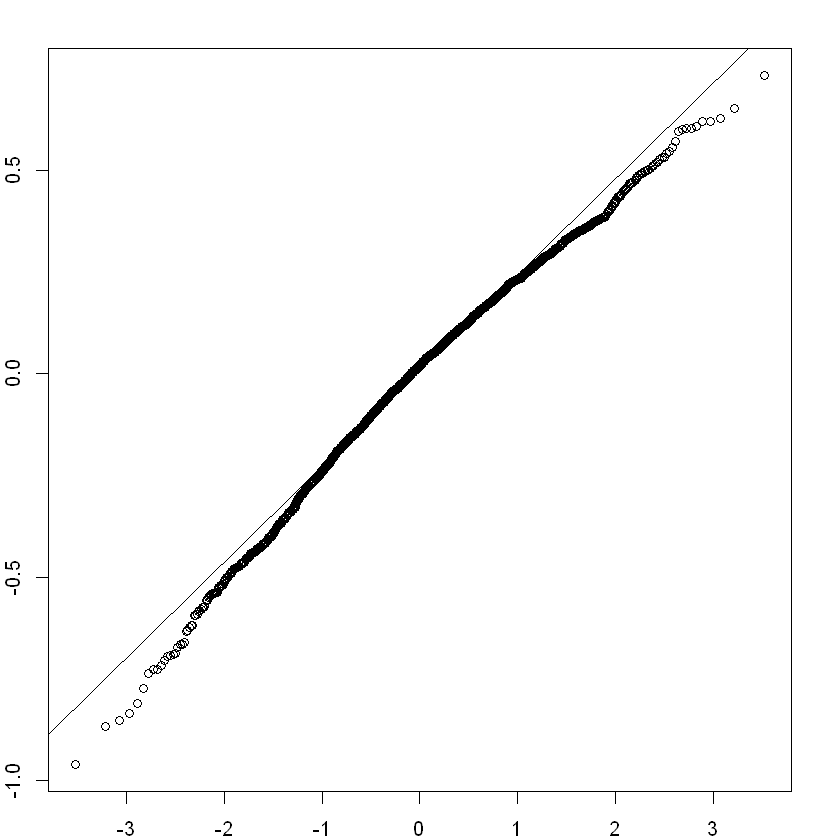

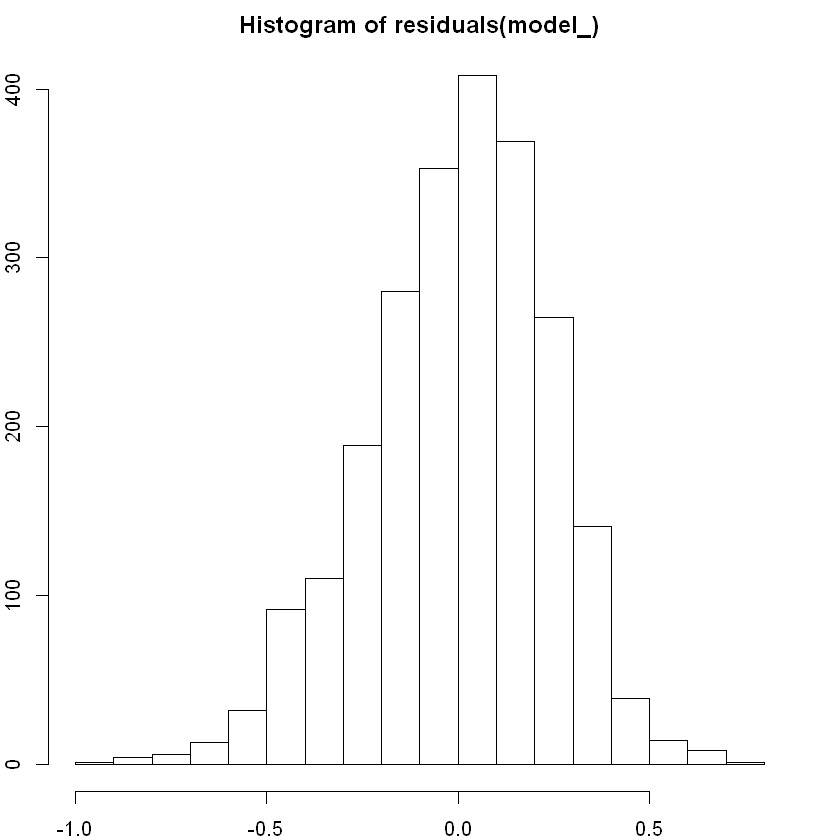

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.024343 0.15602 
 Residual             0.058802 0.24249 
[1] 0.2927765
     2.5%       50%     97.5% 
0.2620762 0.2932486 0.3224118 


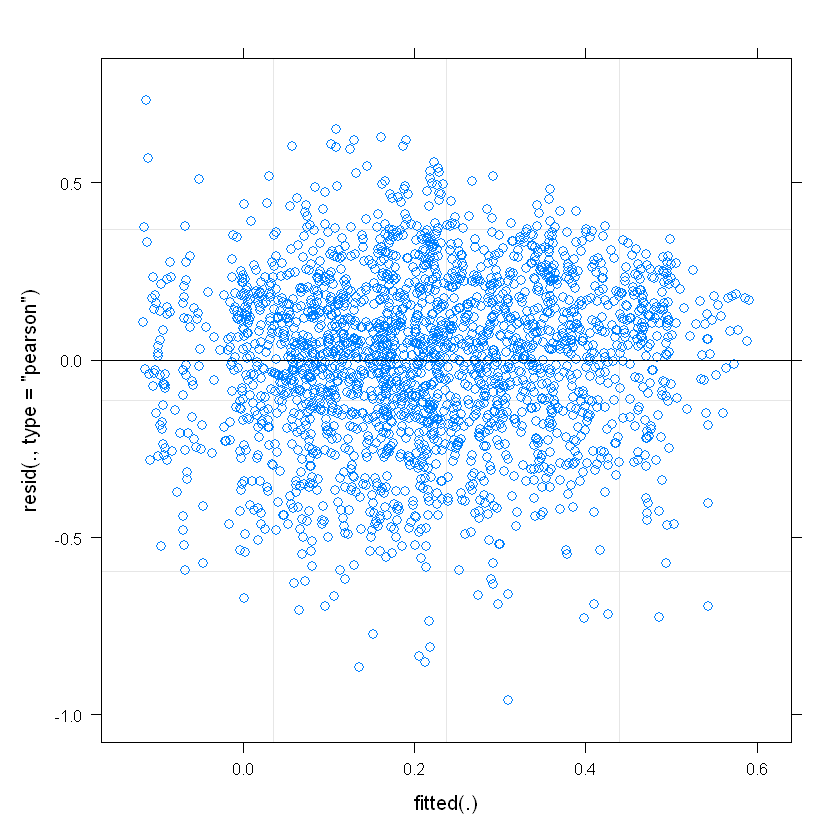

In [13]:
############ LP2
set.seed(1234)
mod_ = rpt(food_sameDurTiming_r50_final ~ scale(weight_interp)+scale(KBF_interp)+scale(DIB)+CLASS+(1|HenID), 
                       grname = c("HenID"), data = df_selOFH, datatype = "Gaussian", adjusted =TRUE,
                       nboot = nboot_, npermut = 0)
print(mod_)
model_ = mod_$mod
summary(model_)
sim_res = simulateResiduals(model_, n=1000)
plot(sim_res)
par(mar = c(2, 2, 2, 2))
qqnorm(residuals(model_), main = NULL) 
qqline(residuals(model_))
hist(residuals(model_))
plot(model_)

#save results
li_R = append(li_R, mod_$R[[1]]) #only original scale
li_CIL = append(li_CIL, mod_$CI_emp[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'OFH')
li_mvt = append(li_mvt, 'food_sameDurTiming_r50_final')
li_mvtmean = append(li_mvtmean, mean(df_selOFH$food_sameDurTiming_r50_final))

X = further_res(model_, cv=FALSE) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

Bootstrap Progress:


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.334
SE = 0.033
CI = [0.267, 0.395]
P  = 8.39e-141 [LRT]
     NA [Permutation]



Linear mixed model fit by REML ['lmerMod']
Formula: 
food_sameDurTiming_r50_final ~ scale(weight_interp) + scale(KBF_interp) +  
    scale(DIB) + CLASS + (1 | HenID)
   Data: data

REML criterion at convergence: 269.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2921 -0.5972  0.1005  0.6589  2.7280 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.02931  0.1712  
 Residual             0.05848  0.2418  
Number of obs: 2253, groups:  HenID, 98

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           0.246378   0.022513  10.944
scale(weight_interp) -0.007957   0.013166  -0.604
scale(KBF_interp)     0.008916   0.011066   0.806
scale(DIB)            0.016200   0.009319   1.738
CLASSLEXP             0.005222   0.054053   0.097
CLASSMEXP             0.029601   0.045875   0.645

Correlation of Fixed Effects:
            (Intr) scl(_) s(KBF_ s(DIB) CLASSL
scl(wght_n)  0.028                            
scl(KBF_nt) 

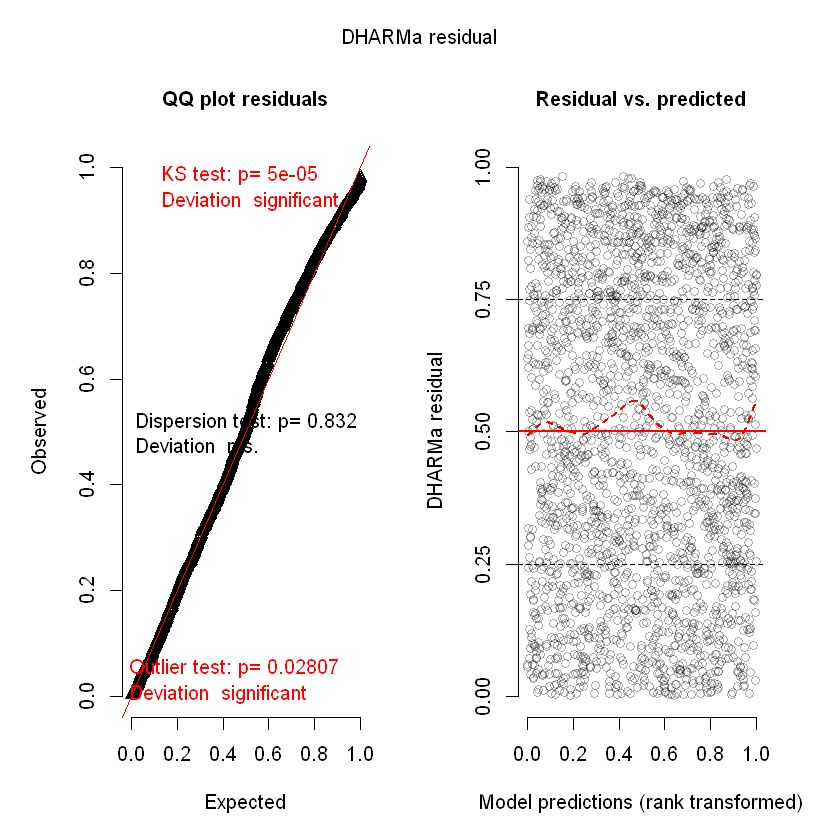

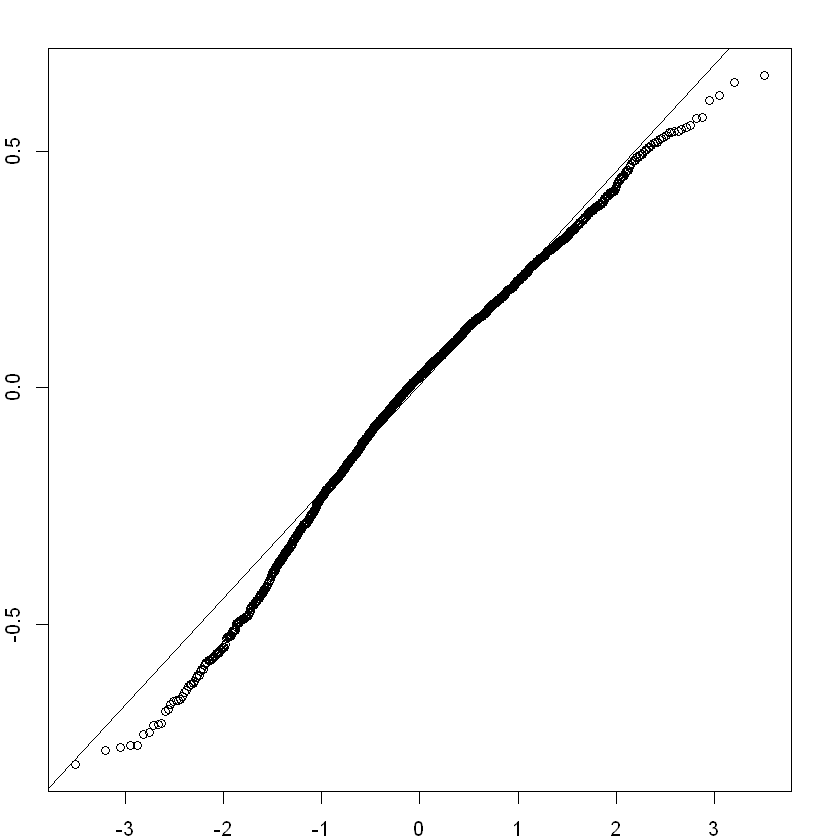

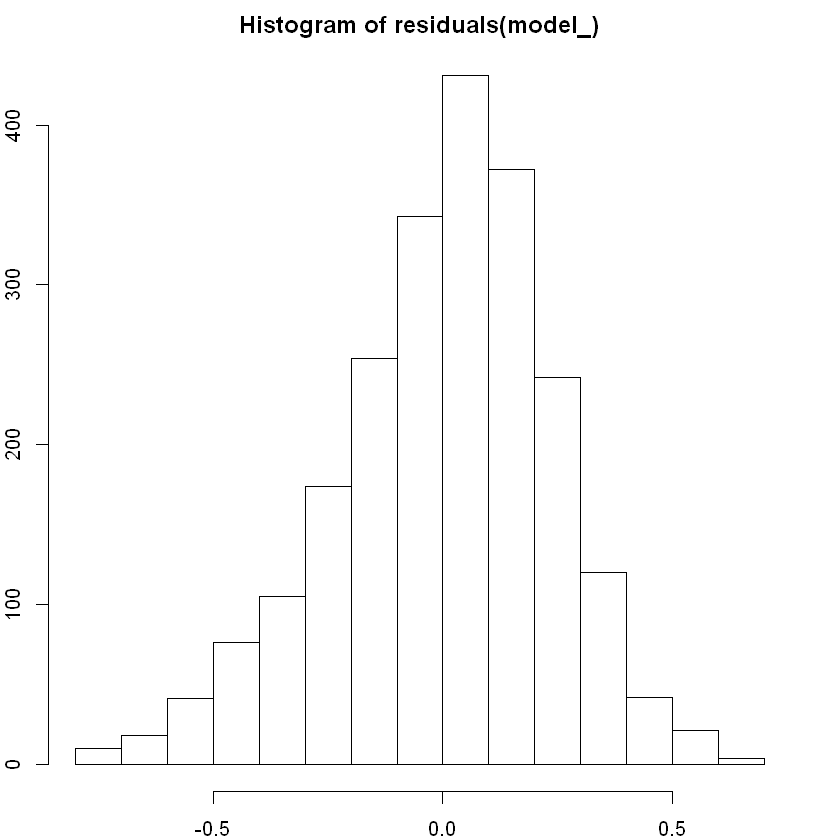

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.029314 0.17121 
 Residual             0.058481 0.24183 
[1] 0.3338905
     2.5%       50%     97.5% 
0.3023982 0.3331531 0.3635426 


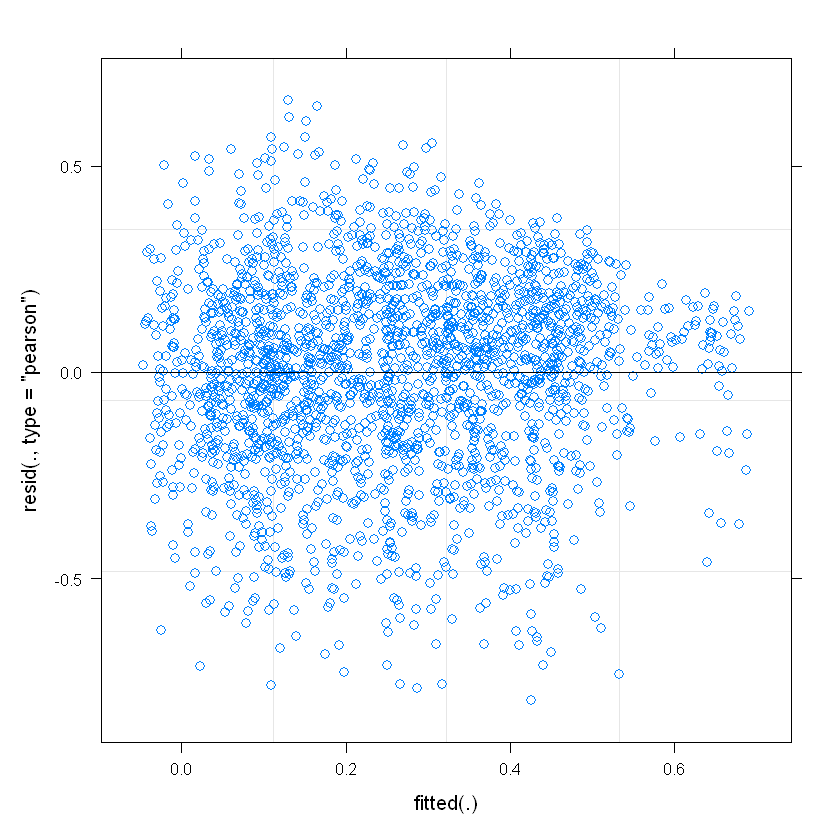

In [14]:
############ LP10
set.seed(1234)
mod_ = rpt(food_sameDurTiming_r50_final ~ scale(weight_interp)+scale(KBF_interp)+scale(DIB)+CLASS+(1|HenID), 
                       grname = c("HenID"), data = df_selTRAN, datatype = "Gaussian", adjusted =TRUE,
                       nboot = nboot_, npermut = 0)
print(mod_)
model_ = mod_$mod
summary(model_)
sim_res = simulateResiduals(model_, n=1000)
plot(sim_res)
par(mar = c(2, 2, 2, 2))
qqnorm(residuals(model_), main = NULL) 
qqline(residuals(model_))
hist(residuals(model_))
plot(model_)

#save results
li_R = append(li_R, mod_$R[[1]]) #only original scale
li_CIL = append(li_CIL, mod_$CI_emp[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'TRAN')
li_mvt = append(li_mvt, 'food_sameDurTiming_r50_final')
li_mvtmean = append(li_mvtmean, mean(df_selTRAN$food_sameDurTiming_r50_final))

X = further_res(model_, cv=FALSE) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

In [15]:
#save results
df_res = data.frame(li_R, li_CIL, li_CIU, li_ngroup, li_nobs, li_BStype, li_mvt, li_mvtmean,
                    li_VI, li_VE, li_popintercept, li_CVI, li_CVE)
write.csv(df_res, file.path(path_ ,'OFH_R_estimates_FOOD.csv'))
df_res

li_R,li_CIL,li_CIU,li_ngroup,li_nobs,li_BStype,li_mvt,li_mvtmean,li_VI,li_VE,li_popintercept,li_CVI,li_CVE
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
0.2927765,0.2311536,0.3537297,96,2325,OFH,food_sameDurTiming_r50_final,0.2143398,"0.0243 [0.0211, 0.0276]","0.0588 [0.0556, 0.0623]","0.2088 [0.1668, 0.2509]",NA,NA
0.3338905,0.2671234,0.3952198,98,2253,TRAN,food_sameDurTiming_r50_final,0.2586196,"0.0293 [0.0257, 0.0332]","0.0585 [0.0555, 0.0622]","0.2464 [0.2036, 0.2862]",NA,NA


# 3. vertical_travel_distance_fulllight_perinsideh

In [16]:
#initialise list to save results
li_R = c()
li_CIL = c()
li_CIU = c()
li_ngroup = c()
li_nobs = c()
li_BStype = c()
li_mvt = c()
li_mvtmean = c()
li_VI = c()
li_VE = c()
li_popintercept = c()
li_CVI = c()
li_CVE = c()

Bootstrap Progress:


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.683
SE = 0.032
CI = [0.616, 0.735]
P  = 0 [LRT]
     NA [Permutation]



Linear mixed model fit by REML ['lmerMod']
Formula: 
vertical_travel_distance_fulllight_perinsideh ~ scale(weight_interp) +  
    scale(KBF_interp) + scale(DIB) + CLASS + (1 | HenID)
   Data: data

REML criterion at convergence: 7175

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5584 -0.5896 -0.0223  0.5207  8.0868 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 2.335    1.528   
 Residual             1.086    1.042   
Number of obs: 2325, groups:  HenID, 96

Fixed effects:
                     Estimate Std. Error t value
(Intercept)           3.95600    0.19819  19.960
scale(weight_interp)  0.28701    0.06389   4.492
scale(KBF_interp)     0.04106    0.04546   0.903
scale(DIB)           -0.17813    0.03995  -4.459
CLASSLEXP            -0.03249    0.42298  -0.077
CLASSMEXP             0.20342    0.41365   0.492

Correlation of Fixed Effects:
            (Intr) scl(_) s(KBF_ s(DIB) CLASSL
scl(wght_n)  0.009                            
scl

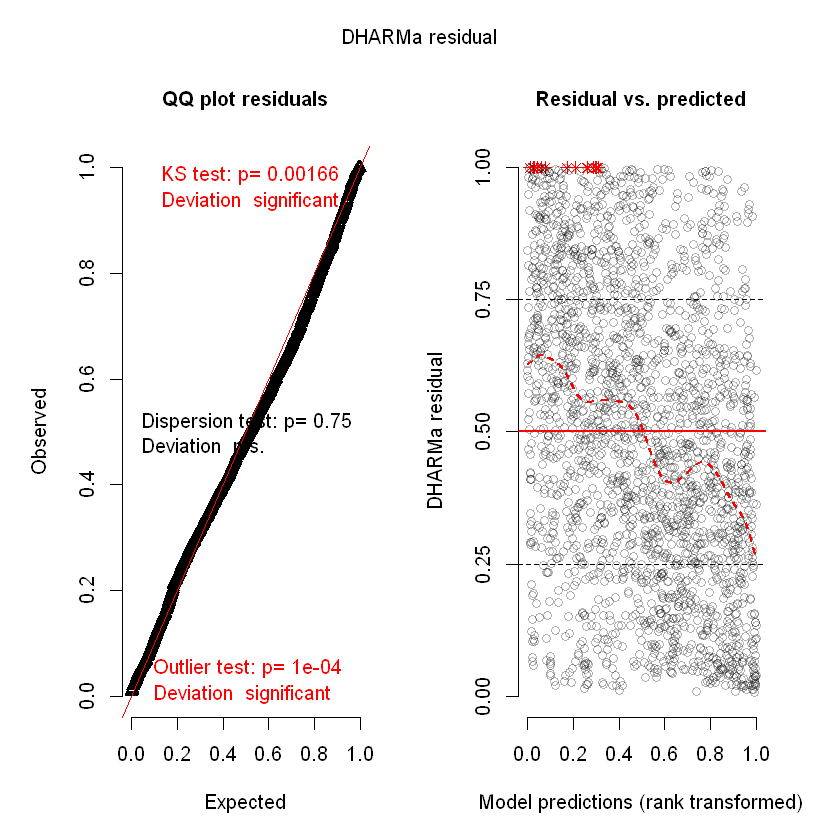

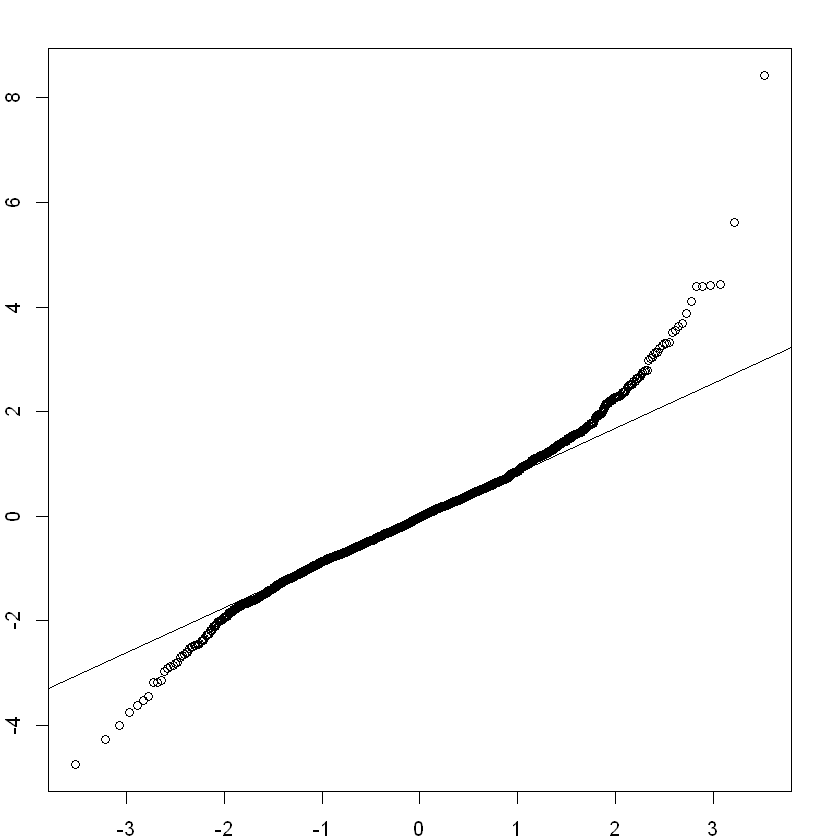

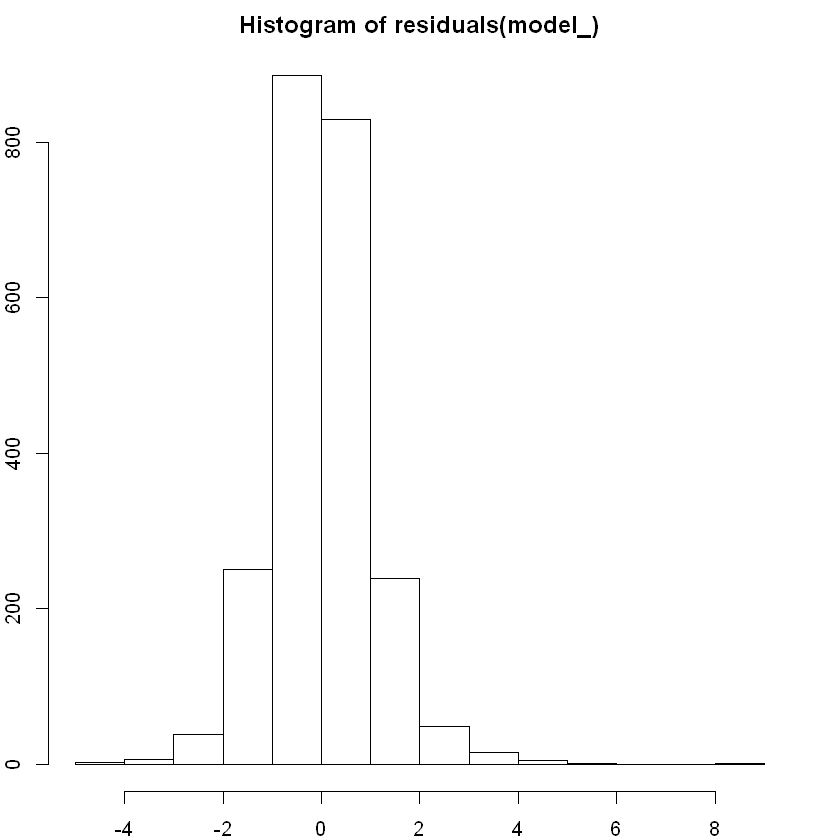

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 2.3352   1.5281  
 Residual             1.0862   1.0422  
[1] 0.6825371
     2.5%       50%     97.5% 
0.6577509 0.6820533 0.7070572 


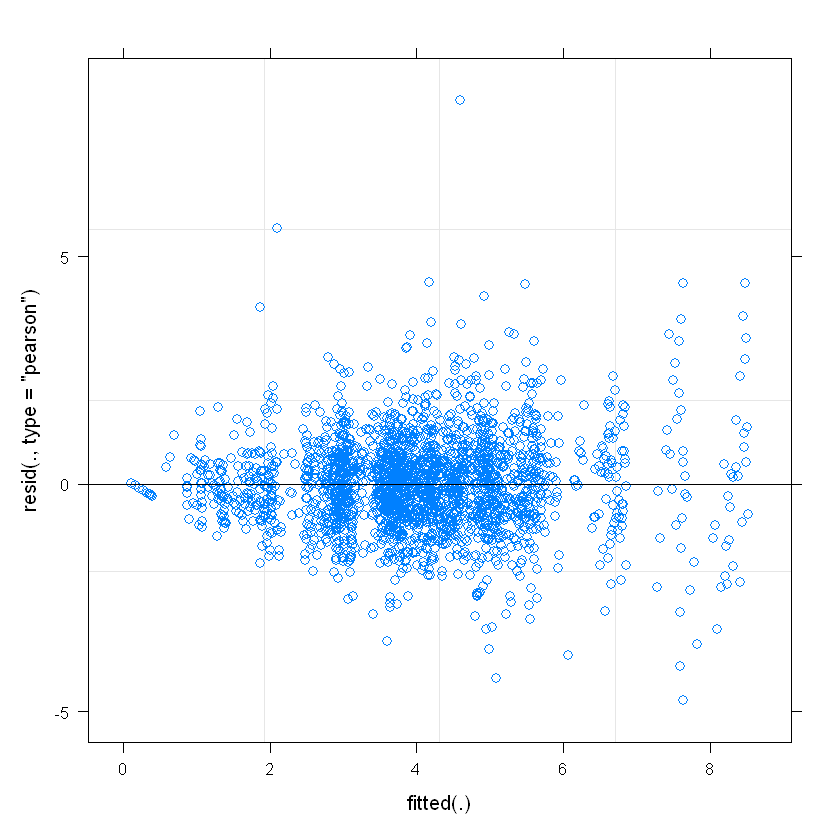

In [17]:
############ LP2
mod_ = rpt(vertical_travel_distance_fulllight_perinsideh ~ scale(weight_interp)+scale(KBF_interp)+scale(DIB)+CLASS +(1|HenID), 
                       grname = c("HenID"), data = df_selOFH, datatype = "Gaussian", adjusted =TRUE,
                       nboot = nboot_, npermut = 0)
print(mod_)
model_ = mod_$mod
summary(model_)
sim_res = simulateResiduals(model_, n=1000)
plot(sim_res)
par(mar = c(2, 2, 2, 2))
qqnorm(residuals(model_), main = NULL) 
qqline(residuals(model_))
hist(residuals(model_))
plot(model_)

#save results
li_R = append(li_R, mod_$R[[1]]) #only original scale
li_CIL = append(li_CIL, mod_$CI_emp[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'OFH')
li_mvt = append(li_mvt, 'vertical_travel_distance_fulllight_perinsideh')
li_mvtmean = append(li_mvtmean, mean(df_selOFH$vertical_travel_distance_fulllight_perinsideh))

X = further_res(model_) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

Bootstrap Progress:


Repeatability estimation using the lmm method 

Repeatability for HenID
R  = 0.611
SE = 0.034
CI = [0.529, 0.67]
P  = 0 [LRT]
     NA [Permutation]



Linear mixed model fit by REML ['lmerMod']
Formula: 
vertical_travel_distance_fulllight_perinsideh ~ scale(weight_interp) +  
    scale(KBF_interp) + scale(DIB) + CLASS + (1 | HenID)
   Data: data

REML criterion at convergence: 7376.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0458 -0.5938 -0.0576  0.5104  5.9592 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 2.078    1.441   
 Residual             1.322    1.150   
Number of obs: 2253, groups:  HenID, 98

Fixed effects:
                      Estimate Std. Error t value
(Intercept)           4.112952   0.182563  22.529
scale(weight_interp)  0.003588   0.072780   0.049
scale(KBF_interp)     0.119390   0.056690   2.106
scale(DIB)           -0.250668   0.047869  -5.237
CLASSLEXP             0.748870   0.443626   1.688
CLASSMEXP             0.079290   0.374600   0.212

Correlation of Fixed Effects:
            (Intr) scl(_) s(KBF_ s(DIB) CLASSL
scl(wght_n)  0.021                       

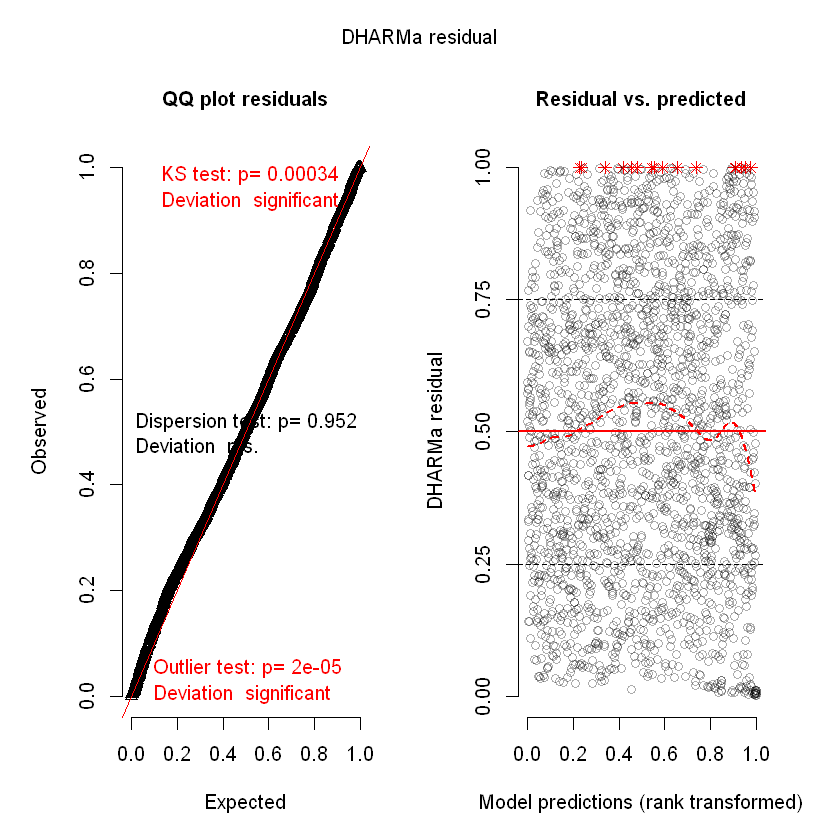

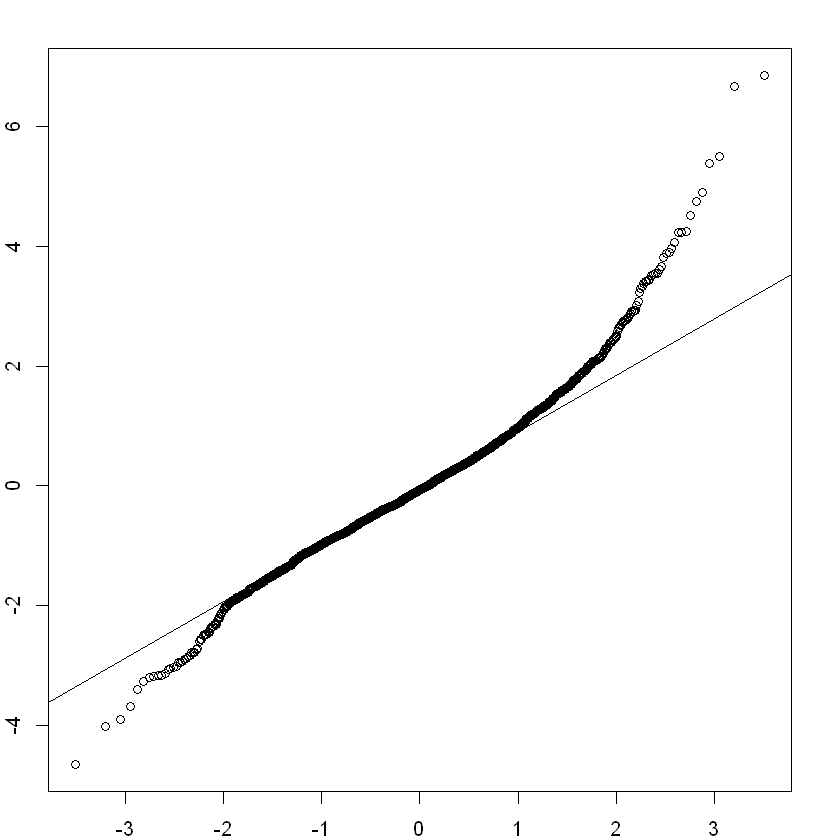

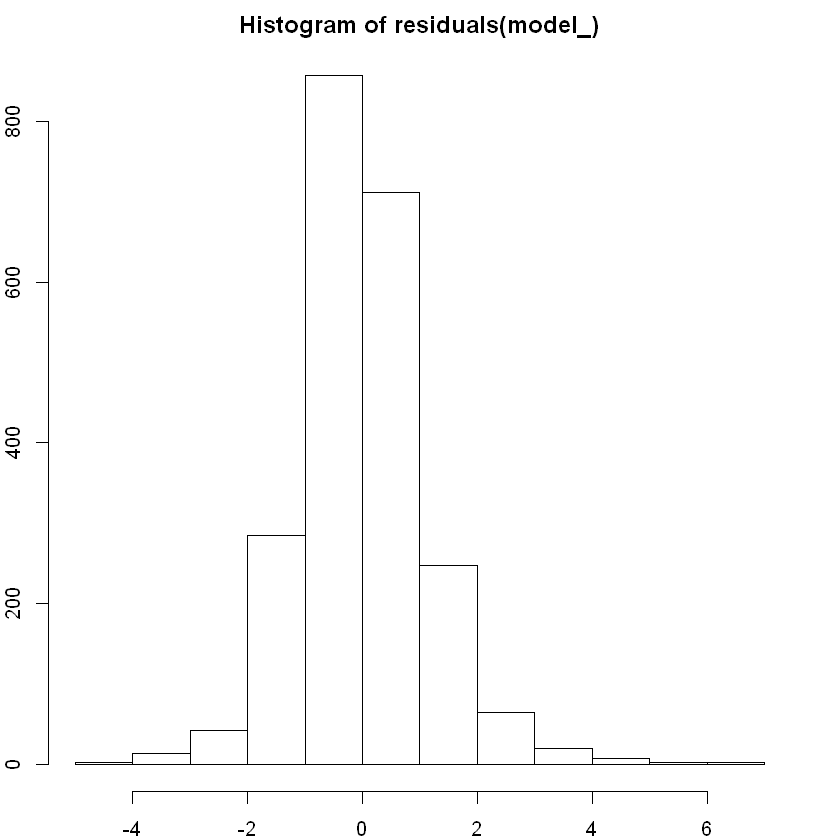

 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 2.0778   1.4414  
 Residual             1.3217   1.1497  
[1] 0.6112047
     2.5%       50%     97.5% 
0.5852992 0.6109320 0.6355803 


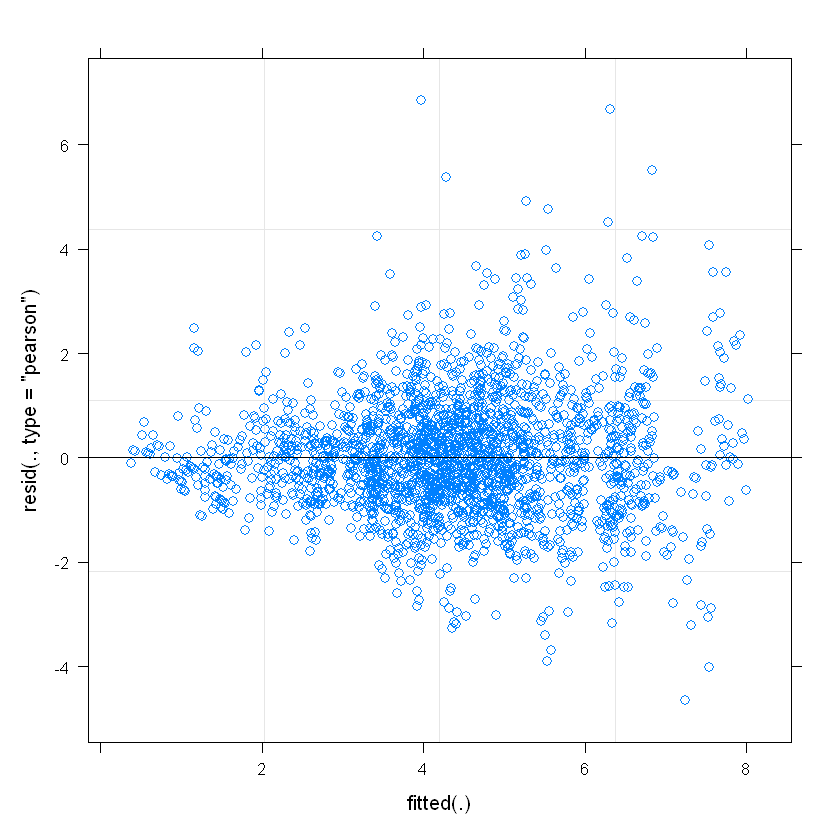

In [18]:
############ LP10
set.seed(1234)
mod_ = rpt(vertical_travel_distance_fulllight_perinsideh ~ scale(weight_interp)+scale(KBF_interp)+scale(DIB)+CLASS+(1|HenID), 
                       grname = c("HenID"), data = df_selTRAN, datatype = "Gaussian", adjusted =TRUE,
                       nboot = nboot_, npermut = 0)
print(mod_)
model_ = mod_$mod
summary(model_)
sim_res = simulateResiduals(model_, n=1000)
plot(sim_res)
par(mar = c(2, 2, 2, 2))
qqnorm(residuals(model_), main = NULL) 
qqline(residuals(model_))
hist(residuals(model_))
plot(model_)

#save results
li_R = append(li_R, mod_$R[[1]]) #only original scale
li_CIL = append(li_CIL, mod_$CI_emp[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'TRAN')
li_mvt = append(li_mvt, 'vertical_travel_distance_fulllight_perinsideh')
li_mvtmean = append(li_mvtmean, mean(df_selTRAN$vertical_travel_distance_fulllight_perinsideh))

X = further_res(model_) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

In [19]:
#save results
df_res = data.frame(li_R, li_CIL, li_CIU, li_ngroup, li_nobs, li_BStype, li_mvt, li_mvtmean,
                   li_VI, li_VE, li_popintercept, li_CVI, li_CVE)
write.csv(df_res, file.path(path_ ,'OFH_R_estimates_VTD.csv'))
df_res

li_R,li_CIL,li_CIU,li_ngroup,li_nobs,li_BStype,li_mvt,li_mvtmean,li_VI,li_VE,li_popintercept,li_CVI,li_CVE
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
0.6825371,0.6163163,0.7347150,96,2325,OFH,vertical_travel_distance_fulllight_perinsideh,4.014659,"2.3352 [2.1263, 2.5746]","1.0862 [1.027, 1.1508]","3.956 [3.5656, 4.3515]","0.7683 [0.7224, 0.8244]","0.524 [0.4958, 0.5561]"
0.6112047,0.5293949,0.6702692,98,2253,TRAN,vertical_travel_distance_fulllight_perinsideh,4.369886,"2.0778 [1.9011, 2.2843]","1.3217 [1.254, 1.4065]","4.113 [3.7677, 4.4361]","0.7108 [0.6717, 0.76]","0.5669 [0.5417, 0.6004]"


# 4. mid_durationafterlightturnedon_Z4_h_Morning

In [20]:
#initialise list to save results
li_R = c()
li_CIL = c()
li_CIU = c()
li_CILbasic = c()
li_CIUbasic = c()
li_CILnorm = c()
li_CIUnorm = c()
li_ngroup = c()
li_nobs = c()
li_BStype = c()
li_mvt = c()
li_mvtmean = c()
li_VI = c()
li_VE = c()
li_popintercept = c()
li_CVI = c()
li_CVE = c()

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df_selOFH, statistic = ICC_R_squared, R = nbr_replicate, 
    sim = "ordinary", main_var = "mid_durationafterlightturnedon_Z4_h_Morning", 
    formula_str = "~ scale(weight_interp) + scale(KBF_interp) + scale(DIB) +CLASS+ (1|HenID)")


Bootstrap Statistics :
      original        bias    std. error
t1* 0.43260763  0.0007004153 0.013371919
t2* 0.63765195  0.0158637363 0.016696826
t3* 0.35435395  0.0251316233 0.017627024
t4* 0.36138011  0.0273271828 0.022646771
t5* 0.05673659  0.0041885143 0.004087451
t6* 0.10026316 -0.0043775182 0.006099262
t7* 2.36009727 -0.0020486616 0.019157921
t8* 0.15504817  0.0056100505 0.005531644
t9* 0.20611317 -0.0045546501 0.006546219

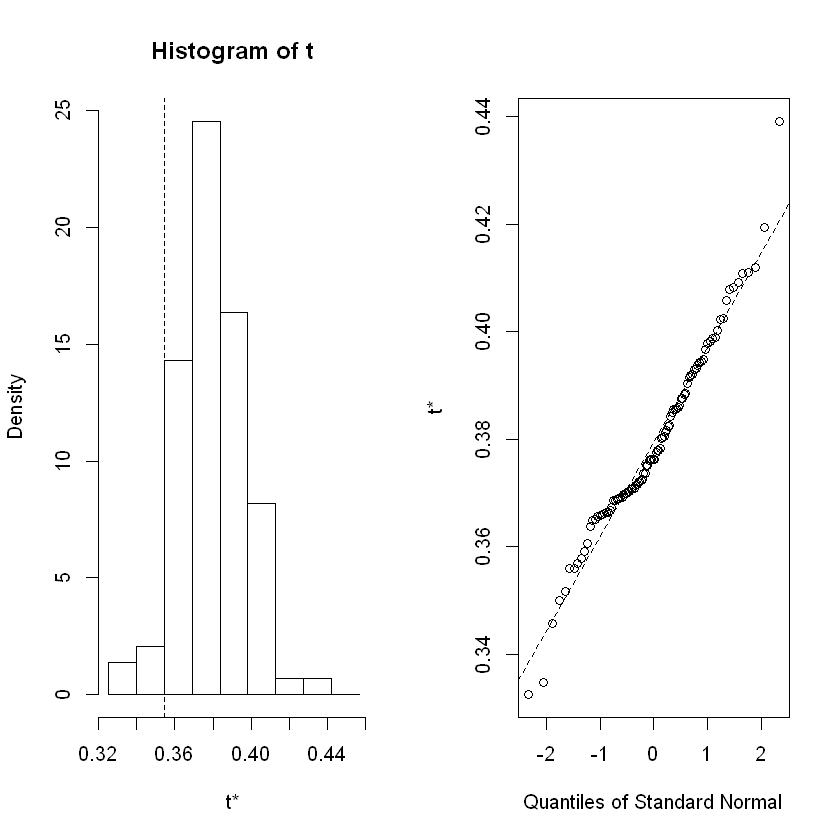

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 100 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = c("norm", "basic", "perc"), 
    index = 4)

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.2897,  0.3784 )   ( 0.2863,  0.3708 )   ( 0.3519,  0.4365 )  
Calculations and Intervals on Original Scale
Some basic intervals may be unstable
Some percentile intervals may be unstable

X1         X2         X3         X4         X5         X6         X7 
0.43330804 0.65351568 0.37948557 0.38870730 0.06092510 0.09588564 2.35804861 
        X8         X9 
0.16065822 0.20155852

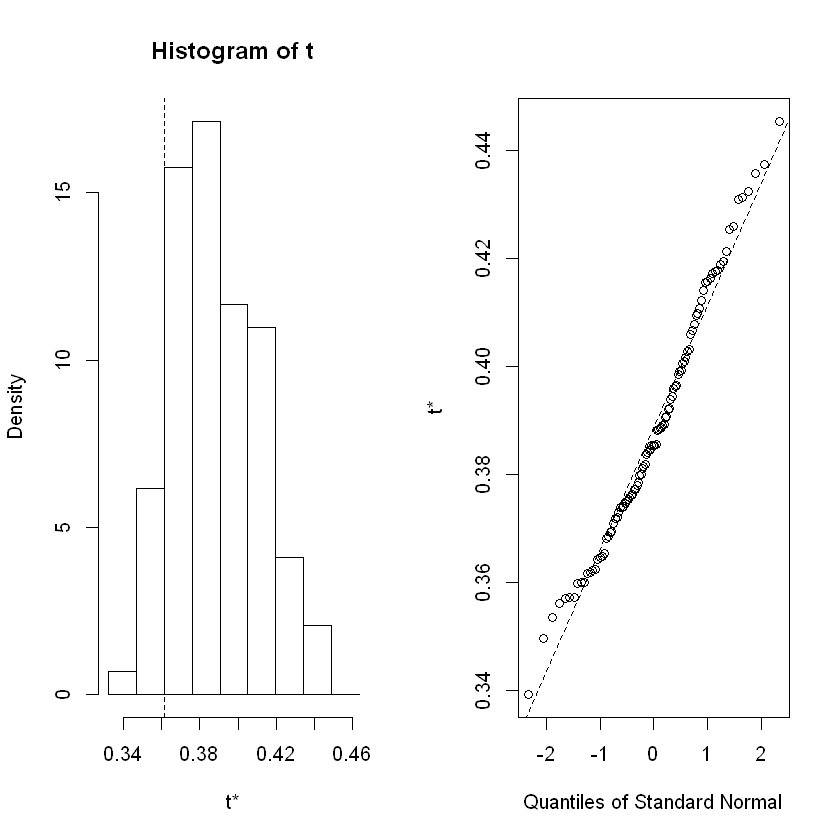

In [21]:
############ LP2
set.seed(1234)
output = boot(data=df_selOFH, statistic=ICC_R_squared, sim='ordinary', R=nbr_replicate, main_var = 'mid_durationafterlightturnedon_Z4_h_Morning',
               formula_str = '~ scale(weight_interp) + scale(KBF_interp) + scale(DIB) +CLASS+ (1|HenID)')
output
# Plotting the output 
plot(output, index=3) 
plot(output, index=4)
#boot.ci(output, type="perc", index=3)
CI_ = boot.ci(output, type=c("norm","basic","perc"), index=4)
CI_
df_Routput = data.frame(output$t)
colMeans(df_Routput)
#--> bais is computed as the mean estiamte over all boot - estiamte based on the orgiinal samples
#save results
#li_R = append(li_R, output[[1]][4]) #1_original, 4: ICC_adj
li_R = append(li_R, colMeans(df_Routput)[[4]]) 
li_CIL = append(li_CIL, CI_$perc[[4]])
li_CIU = append(li_CIU, CI_$perc[[5]])
li_CILbasic = append(li_CILbasic, CI_$basic[[4]])
li_CIUbasic = append(li_CIUbasic, CI_$basic[[5]])
li_CILnorm = append(li_CILnorm, CI_$norm[[2]])
li_CIUnorm = append(li_CIUnorm, CI_$norm[[3]])
li_BStype = append(li_BStype, 'OFH')
li_mvt = append(li_mvt, 'mid_durationafterlightturnedon_Z4_h_Morning')
li_mvtmean = append(li_mvtmean, mean(df_selOFH$mid_cum_Z4_h_Morning))

X = further_res_fromboot(output) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte

Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = integer(0), j = integer(0), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Warning message in Matrix::sparseMatrix(dims = c(0, 0), i = inte


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = df_selTRAN, statistic = ICC_R_squared, R = nbr_replicate, 
    sim = "ordinary", main_var = "mid_durationafterlightturnedon_Z4_h_Morning", 
    formula_str = "~ scale(weight_interp) + scale(KBF_interp) + scale(DIB) +CLASS+ (1|HenID)")


Bootstrap Statistics :
      original       bias    std. error
t1* 0.44424649 -0.014192168 0.042688763
t2* 0.66606891  0.025940886 0.028230689
t3* 0.37023550  0.044680769 0.044143819
t4* 0.39913813  0.056367933 0.069545112
t5* 0.07080699  0.016998723 0.028688267
t6* 0.10659272 -0.005300304 0.008351228
t7* 2.43105057 -0.011780024 0.039627470
t8* 0.17066366  0.018029767 0.029414517
t9* 0.20939522 -0.004927541 0.008593949

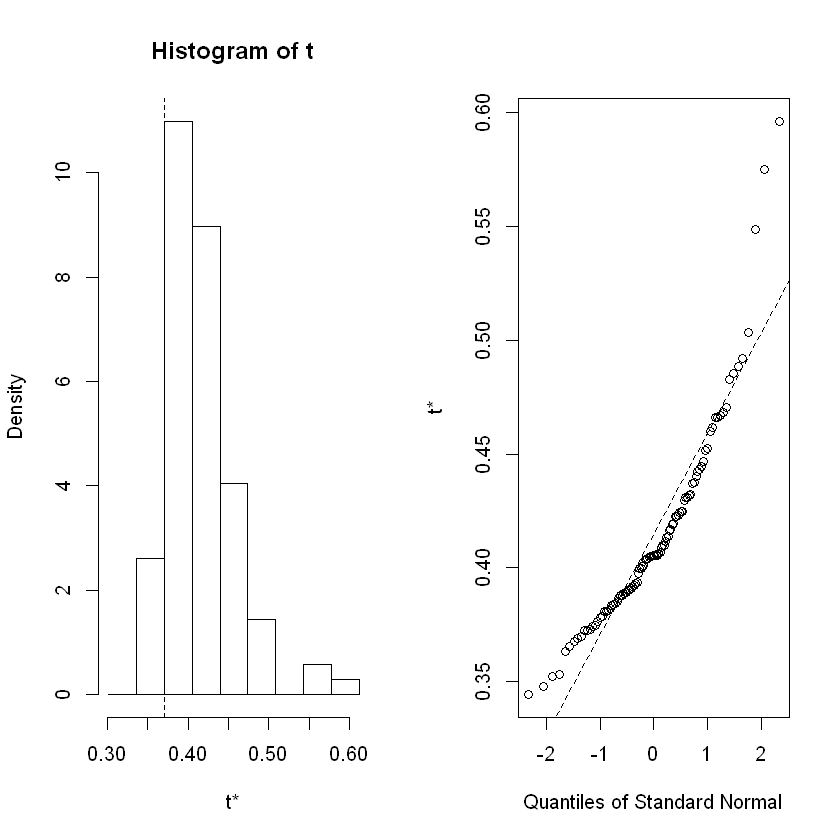

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 100 bootstrap replicates

CALL : 
boot.ci(boot.out = output, type = c("norm", "basic", "perc"), 
    index = 4)

Intervals : 
Level      Normal              Basic              Percentile     
95%   ( 0.2065,  0.4791 )   ( 0.1434,  0.4353 )   ( 0.3629,  0.6549 )  
Calculations and Intervals on Original Scale
Some basic intervals may be unstable
Some percentile intervals may be unstable

X1         X2         X3         X4         X5         X6         X7 
0.43005432 0.69200979 0.41491627 0.45550606 0.08780571 0.10129241 2.41927055 
        X8         X9 
0.18869343 0.20446768

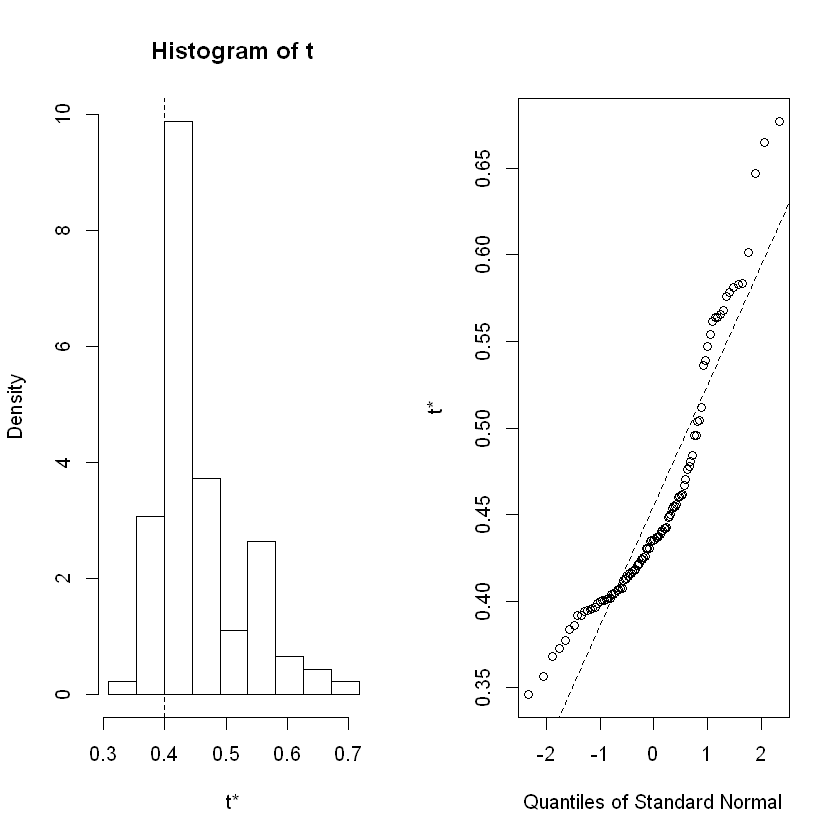

In [22]:
############ LP10
set.seed(123)
output = boot(data=df_selTRAN, statistic=ICC_R_squared, sim='ordinary', R=nbr_replicate, main_var = 'mid_durationafterlightturnedon_Z4_h_Morning',
               formula_str = '~ scale(weight_interp) + scale(KBF_interp) + scale(DIB) +CLASS+ (1|HenID)')
output
# Plotting the output 
plot(output, index=3) 
plot(output, index=4)
#boot.ci(output, type="perc", index=3)
CI_ = boot.ci(output, type=c("norm","basic","perc"), index=4)
CI_
df_Routput = data.frame(output$t)
colMeans(df_Routput)
#--> bais is computed as the mean estiamte over all boot - estiamte based on the orgiinal samples
#save results
#li_R = append(li_R, output[[1]][4]) #1_original, 4: ICC_adj
li_R = append(li_R, colMeans(df_Routput)[[4]]) 
li_CIL = append(li_CIL, CI_$perc[[4]])
li_CIU = append(li_CIU, CI_$perc[[5]])
li_CILbasic = append(li_CILbasic, CI_$basic[[4]])
li_CIUbasic = append(li_CIUbasic, CI_$basic[[5]])
li_CILnorm = append(li_CILnorm, CI_$norm[[2]])
li_CIUnorm = append(li_CIUnorm, CI_$norm[[3]])
li_BStype = append(li_BStype, 'TRAN')
li_mvt = append(li_mvt, 'mid_durationafterlightturnedon_Z4_h_Morning')
li_mvtmean = append(li_mvtmean, mean(df_selTRAN$mid_cum_Z4_h_Morning))

X = further_res_fromboot(output) #output: VI_t, VE_t, popintercept_t, CVI_t, CVE_t
li_VI = append(li_VI, X[1])
li_VE = append(li_VE, X[2])
li_popintercept = append(li_popintercept, X[3])
li_CVI = append(li_CVI, X[4])
li_CVE = append(li_CVE, X[5])

In [23]:
#save results
df_res = data.frame(li_R, li_CIL, li_CIU, li_CILbasic, li_CIUbasic, li_BStype, li_mvt, li_mvtmean,
                   li_VI, li_VE, li_popintercept, li_CVI, li_CVE)
write.csv(df_res, file.path(path_ ,'OFH_R_estimates_MZ4.csv'))
df_res

li_R,li_CIL,li_CIU,li_CILbasic,li_CIUbasic,li_BStype,li_mvt,li_mvtmean,li_VI,li_VE,li_popintercept,li_CVI,li_CVE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
0.3887073,0.3519115,0.4364667,0.2862935,0.3708488,OFH,mid_durationafterlightturnedon_Z4_h_Morning,4.555861,"0.0609 [0.0531, 0.0694]","0.0959 [0.0844, 0.1082]","2.358 [2.3165, 2.398]","0.1607 [0.15, 0.1721]","0.2016 [0.1884, 0.2146]"
0.4555061,0.3629402,0.6548680,0.1434082,0.4353361,TRAN,mid_durationafterlightturnedon_Z4_h_Morning,4.572754,"0.0878 [0.0641, 0.1861]","0.1013 [0.0847, 0.1196]","2.4193 [2.3226, 2.4806]","0.1887 [0.1615, 0.2832]","0.2045 [0.1864, 0.2221]"


# 5. WentinWG

In [24]:
#initialise list to save results
li_R = c()
li_CIL = c()
li_CIU = c()
li_ngroup = c()
li_nobs = c()
li_BStype = c()
li_mvt = c()
li_mvtmean = c()
li_VI = c()
li_VE = c()

Bootstrap Progress:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.528
SE = 0.047
CI = [0.411, 0.584]
P  = 1.65e-165 [LRT]
     NA [Permutation]

Original-scale approximation:
R  = 0.662
SE = 0.094
CI = [0.48, 0.807]
P  = 1.65e-165 [LRT]
     NA [Permutation]


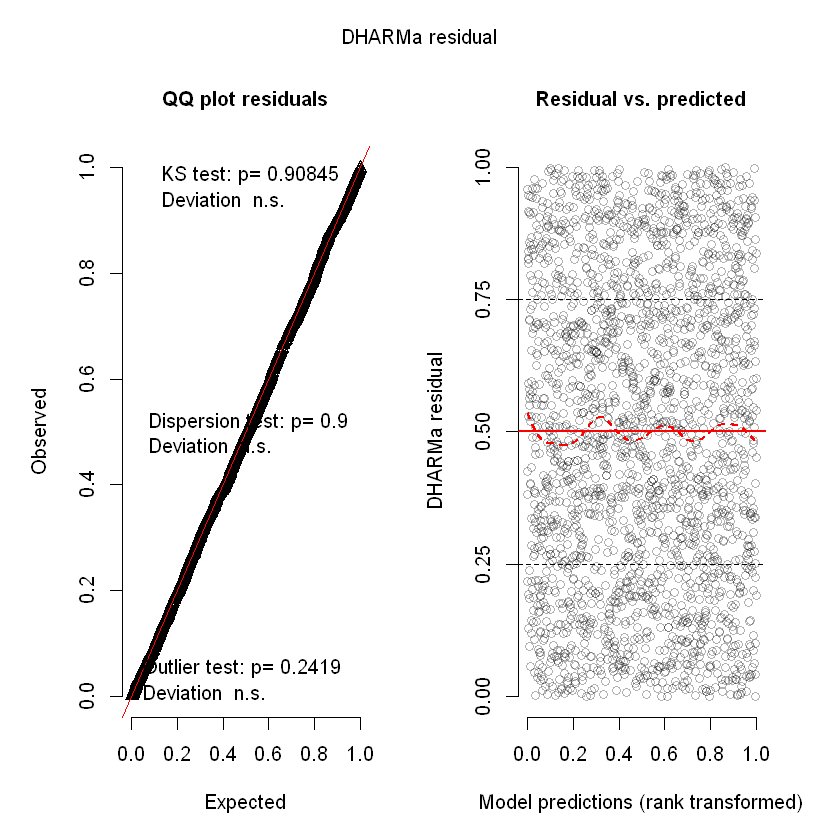

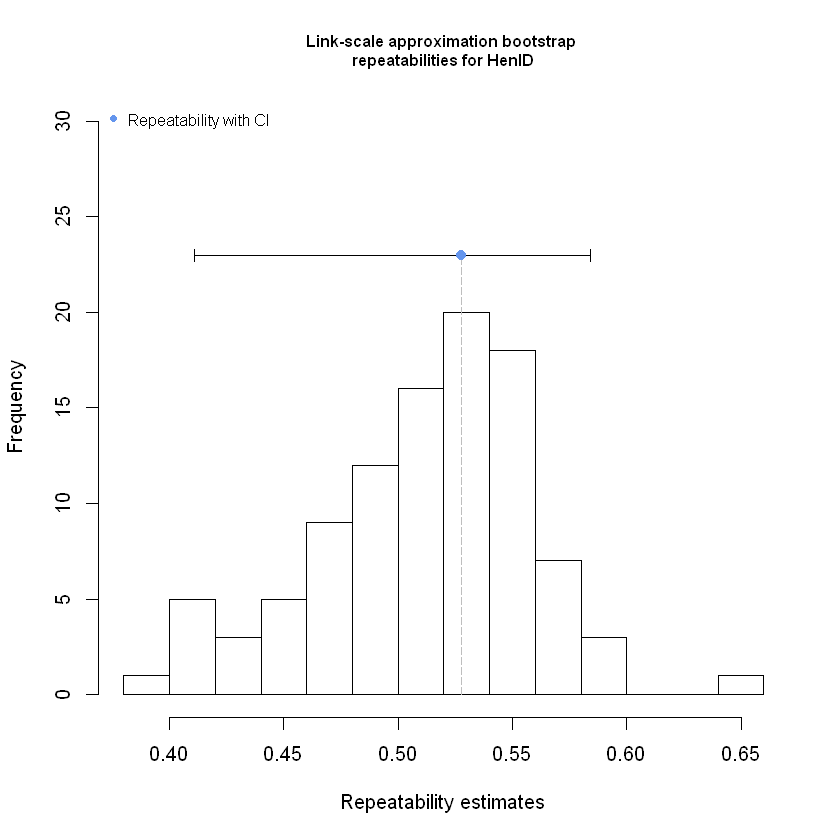

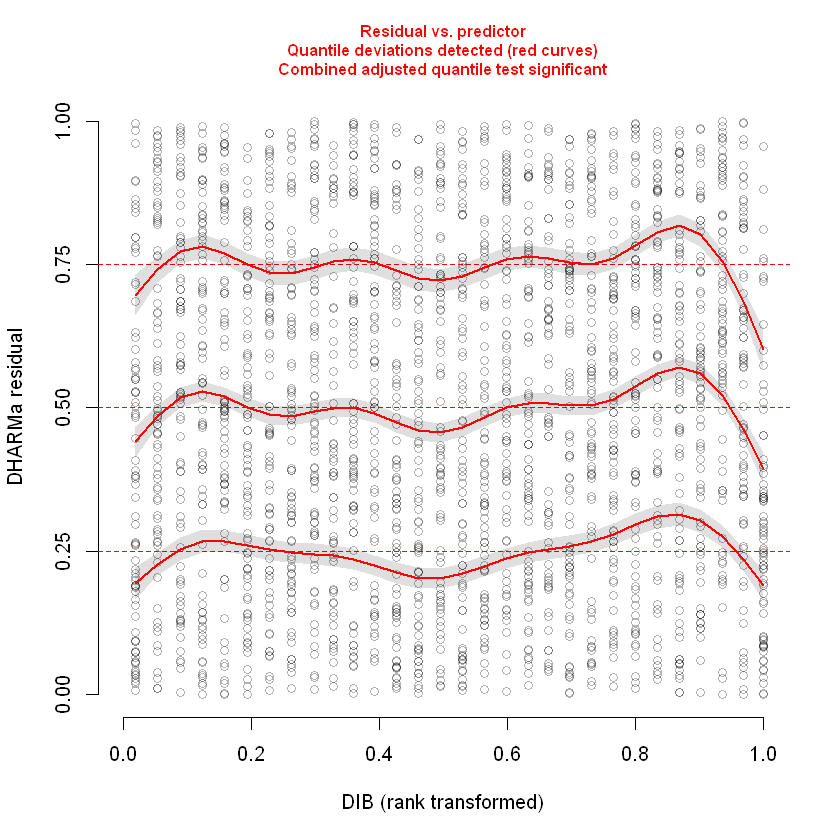

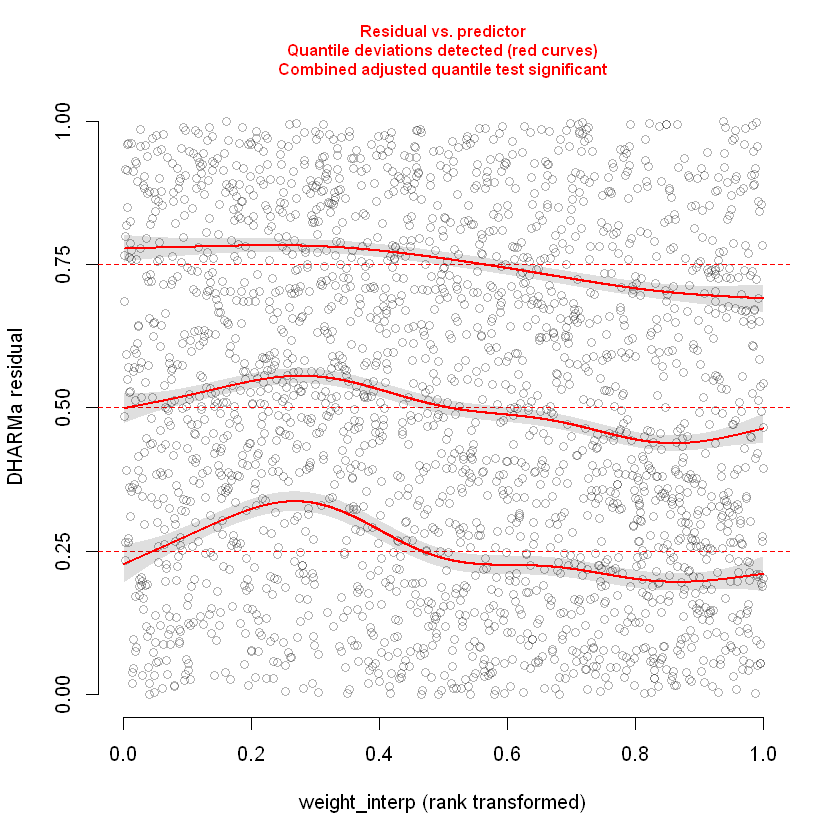


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 1.0065, p-value = 0.9
alternative hypothesis: two.sided


Bootstrap Progress:




Variance estimation using the glmm method and logit link 

Variance of HenID
--------------------------------
Link-scale approximation:
Var = 4.725
SE = 0.861
CI = [2.996, 6.26]
P  = 1.65e-165 [LRT]
     NA [Permutation]

Variance of Residual
--------------------------------
Link-scale approximation:
Var = 4.231
SE = 0.137
CI = [4.079, 4.575]
P  = NA [LRT]
     NA [Permutation]


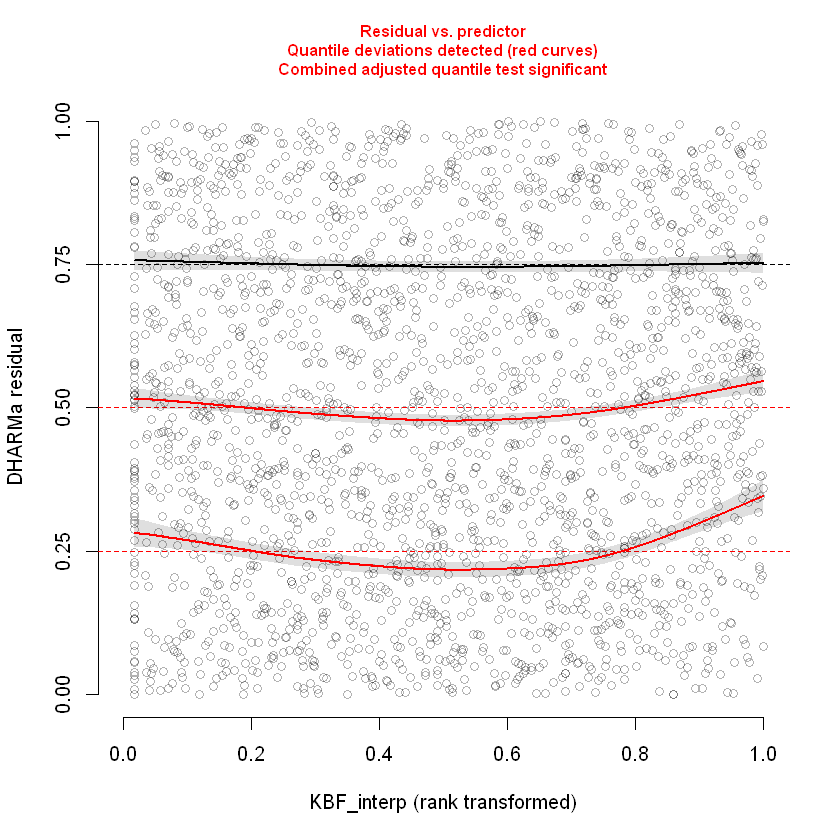

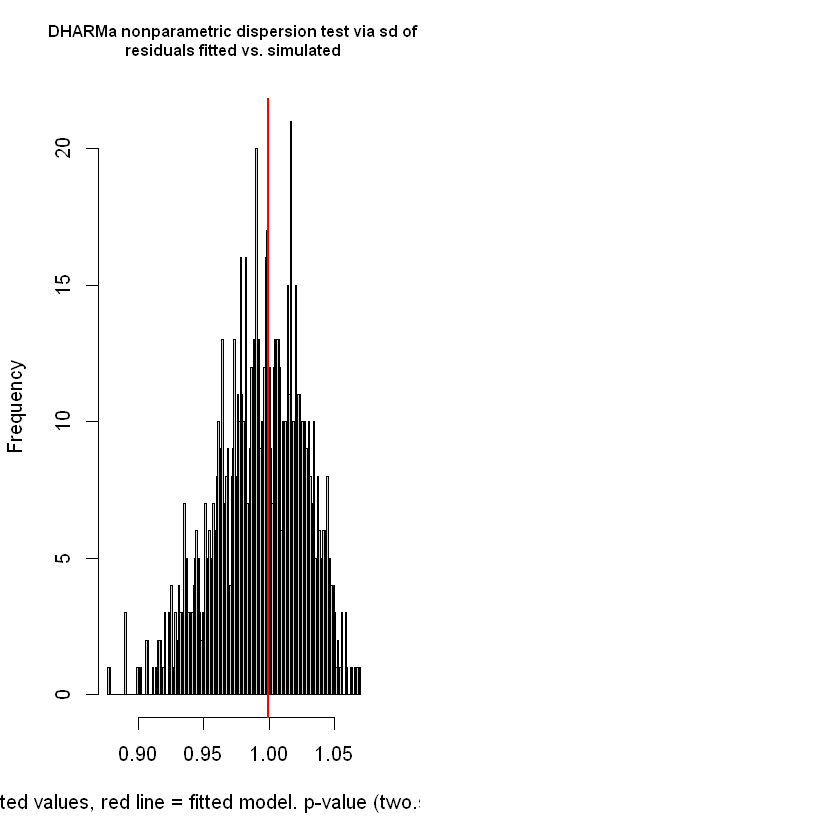

In [25]:
#LP2
#defaults to logit
set.seed(1234)
mod_ = rpt(WentinWG ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp) + (1|HenID),
               grname=c("HenID"), datatype="Binary", data=df_selOFH, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit') 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)
plot(mod_, grname = "HenID", type = "boot", cex.main = 0.8)
plotResiduals(sim_res, df_selOFH$DIB, quantreg = T)
plotResiduals(sim_res, df_selOFH$weight_interp, quantreg = T)
plotResiduals(sim_res, df_selOFH$KBF_interp, quantreg = T)
par(mfrow = c(1,2))
testDispersion(sim_res)

#save results
li_R = append(li_R, mod_$R[[1]][2]) #2: link scale
li_CIL = append(li_CIL, mod_$CI_emp$CI_link[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp$CI_link[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'OFH')
li_mvt = append(li_mvt, 'WentinWG')
li_mvtmean = append(li_mvtmean, mean(df_selOFH$WentinWG))

#add VI,VE
mod_ = rpt(WentinWG ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp) + (1|HenID),
               grname=c("HenID",'Residual'), datatype="Binary", data=df_selOFH, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit', ratio=FALSE)  # shouldnt be here: 'Overdispersion'
mod_
VI = round(mod_$R['R_link','HenID'], 4) #henid var
VI_L = round(mod_$CI_emp$CI_link['HenID','2.5%'], 4)
VI_U = round(mod_$CI_emp$CI_link['HenID','97.5%'], 4)
VE = round(mod_$R['R_link','Residual'], 4) #residual var
VE_L = round(mod_$CI_emp$CI_link['Residual','2.5%'], 4)
VE_U = round(mod_$CI_emp$CI_link['Residual','97.5%'], 4)
li_VI = append(li_VI,paste0(as.character(VI),' [', as.character(VI_L), ', ', as.character(VI_U), ']')) 
li_VE = append(li_VE, paste0(as.character(VE),' [', as.character(VE_L), ', ', as.character(VE_U), ']'))

Bootstrap Progress:




Repeatability estimation using the glmm method and logit link 

Repeatability for HenID
--------------------------------
Link-scale approximation:
R  = 0.432
SE = 0.047
CI = [0.323, 0.51]
P  = 3.64e-110 [LRT]
     NA [Permutation]

Original-scale approximation:
R  = 0.503
SE = 0.082
CI = [0.371, 0.699]
P  = 3.64e-110 [LRT]
     NA [Permutation]


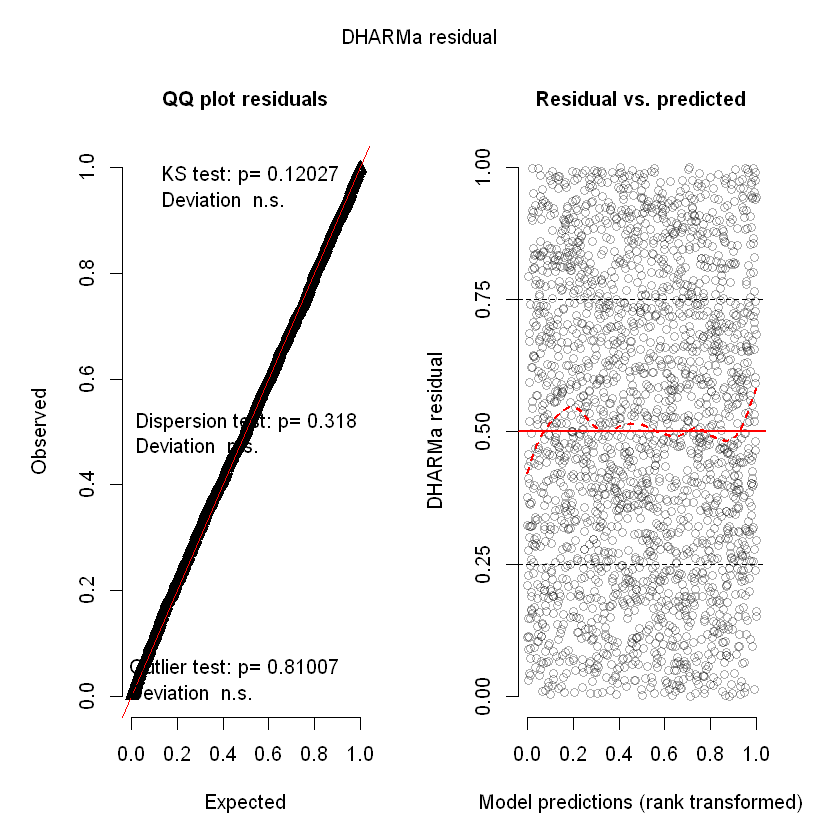

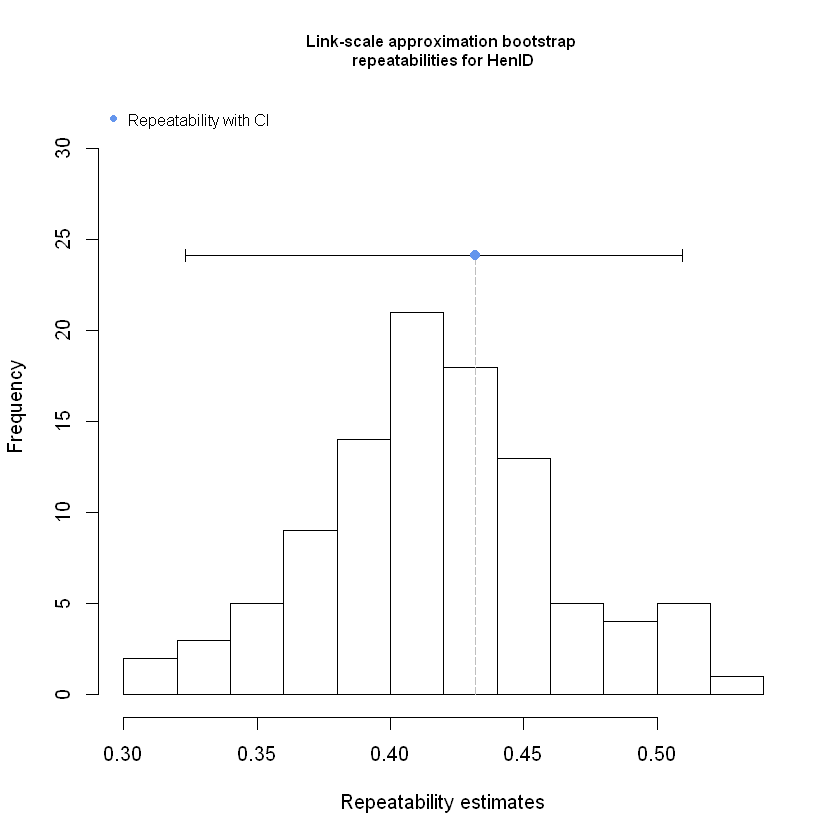

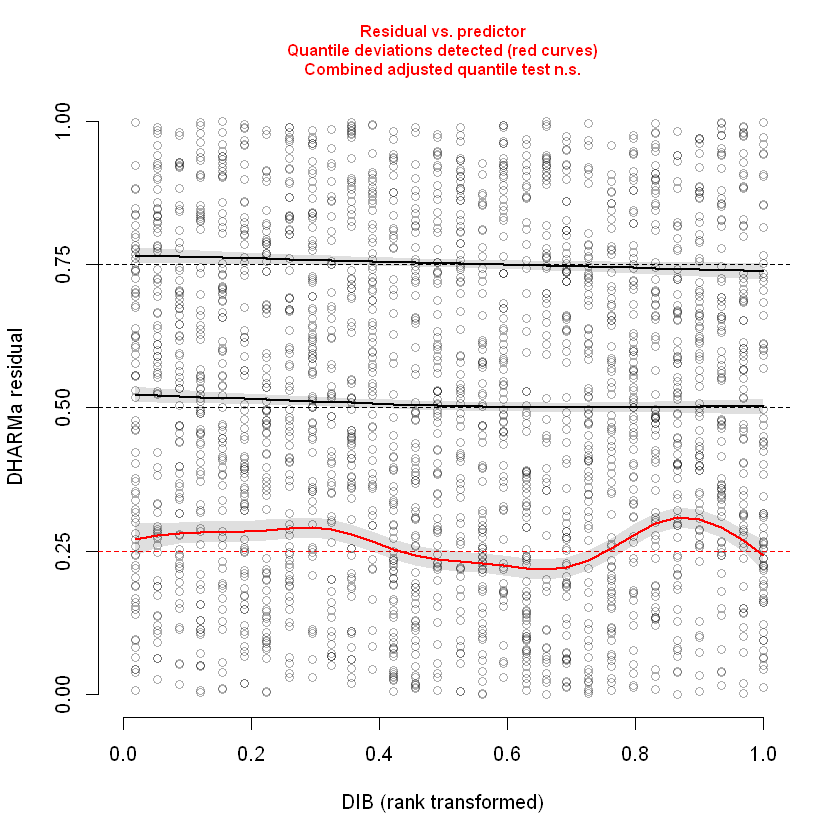

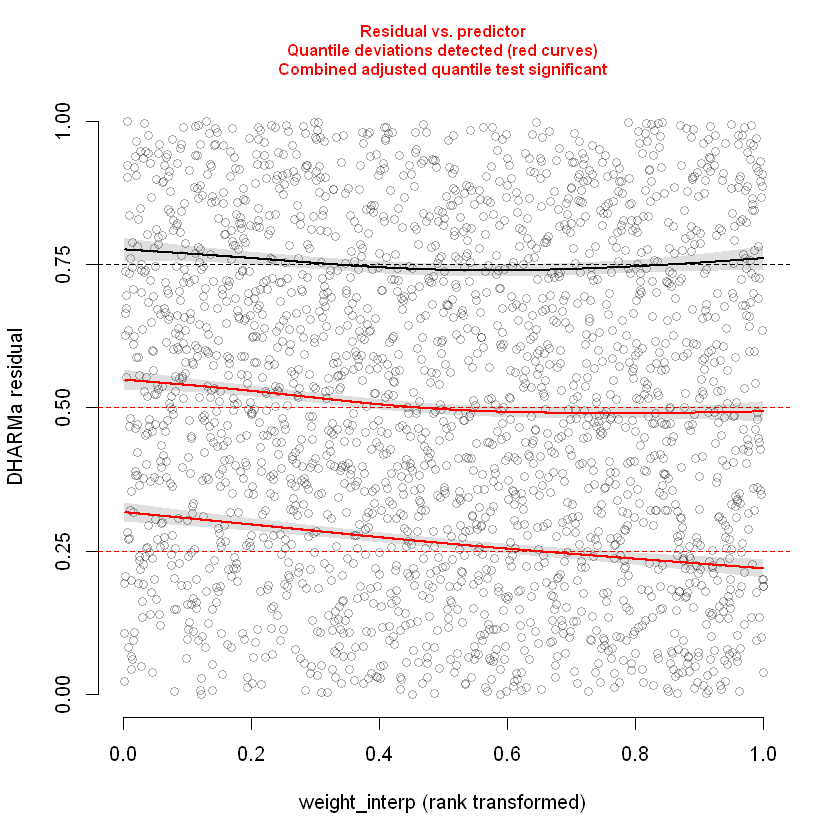


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 0.95446, p-value = 0.318
alternative hypothesis: two.sided


Bootstrap Progress:




Variance estimation using the glmm method and logit link 

Variance of HenID
--------------------------------
Link-scale approximation:
Var = 3.529
SE = 0.665
CI = [2.329, 4.89]
P  = 3.64e-110 [LRT]
     NA [Permutation]

Variance of Residual
--------------------------------
Link-scale approximation:
Var = 4.644
SE = 0.229
CI = [4.174, 5.056]
P  = NA [LRT]
     NA [Permutation]


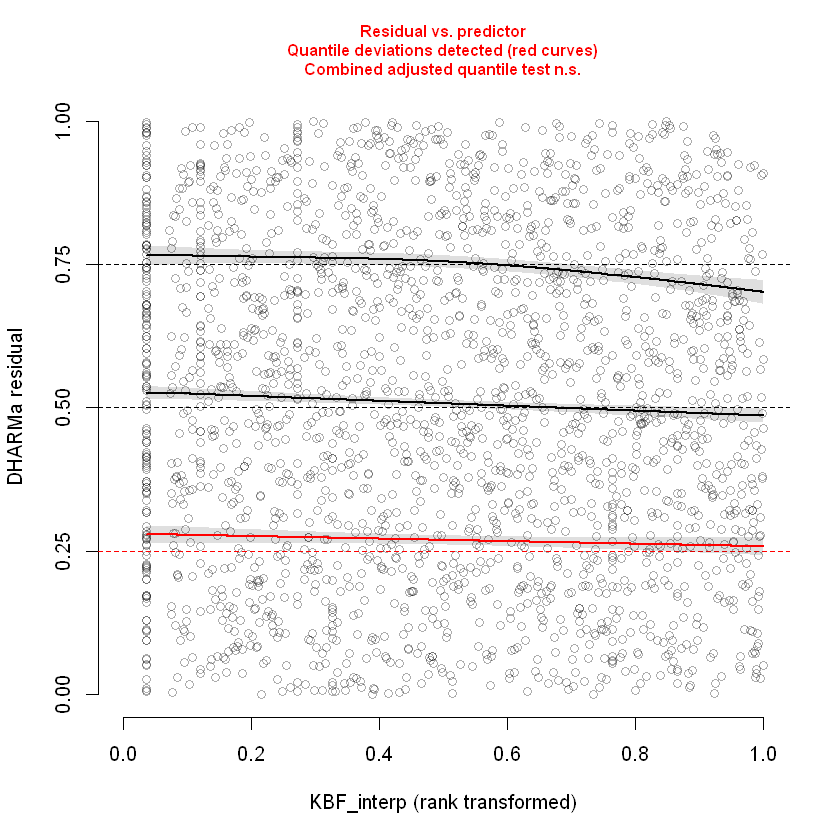

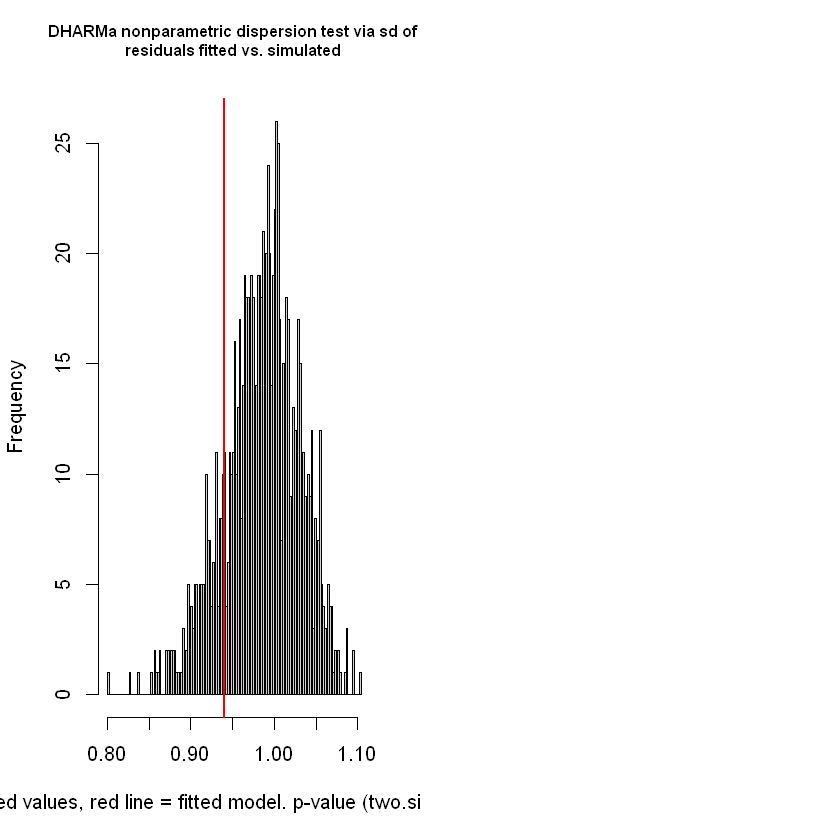

In [26]:
#LP10
#defaults to logit
set.seed(1234)
mod_ = rpt(WentinWG ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp)+ (1|HenID),
               grname=c("HenID"), datatype="Binary", data=df_selTRAN, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit') 
mod_
sim_res = simulateResiduals(mod_$mod, n=1000)
plot(sim_res)
plot(mod_, grname = "HenID", type = "boot", cex.main = 0.8)
plotResiduals(sim_res, df_selTRAN$DIB, quantreg = T)
plotResiduals(sim_res, df_selTRAN$weight_interp, quantreg = T)
plotResiduals(sim_res, df_selTRAN$KBF_interp, quantreg = T)
par(mfrow = c(1,2))
testDispersion(sim_res)

#save results
li_R = append(li_R, mod_$R[[1]][2]) #2: link scale
li_CIL = append(li_CIL, mod_$CI_emp$CI_link[,'2.5%'])
li_CIU = append(li_CIU, mod_$CI_emp$CI_link[,'97.5%'])
li_ngroup = append(li_ngroup, mod_$ngroups[['HenID']])
li_nobs = append(li_nobs, mod_$nobs)
li_BStype = append(li_BStype, 'TRAN')
li_mvt = append(li_mvt, 'WentinWG')
li_mvtmean = append(li_mvtmean, mean(df_selTRAN$WentinWG))

#add VI,VE
mod_ = rpt(WentinWG ~ scale(weight_interp)+scale(DIB) + scale(KBF_interp)+ (1|HenID),
               grname=c("HenID",'Residual'), datatype="Binary", data=df_selTRAN, adjusted=TRUE, nboot=nboot_, npermut=0,
               link='logit', ratio=FALSE)  # shouldnt be here: 'Overdispersion'
mod_
VI = round(mod_$R['R_link','HenID'], 4) #henid var
VI_L = round(mod_$CI_emp$CI_link['HenID','2.5%'], 4)
VI_U = round(mod_$CI_emp$CI_link['HenID','97.5%'], 4)
VE = round(mod_$R['R_link','Residual'], 4) #residual var
VE_L = round(mod_$CI_emp$CI_link['Residual','2.5%'], 4)
VE_U = round(mod_$CI_emp$CI_link['Residual','97.5%'], 4)
li_VI = append(li_VI,paste0(as.character(VI),' [', as.character(VI_L), ', ', as.character(VI_U), ']')) 
li_VE = append(li_VE, paste0(as.character(VE),' [', as.character(VE_L), ', ', as.character(VE_U), ']'))

In [27]:
#save results
df_res = data.frame(li_R, li_CIL, li_CIU, li_ngroup, li_nobs, li_BStype, li_mvt, li_mvtmean,
                   li_VI, li_VE)
write.csv(df_res, file.path(path_ ,'OFH_R_estimates_WG.csv'))
df_res

li_R,li_CIL,li_CIU,li_ngroup,li_nobs,li_BStype,li_mvt,li_mvtmean,li_VI,li_VE
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<dbl>,<fct>,<fct>
0.527571,0.4110243,0.5841018,96,2325,OFH,WentinWG,0.6167742,"4.7246 [2.9962, 6.2603]","4.2308 [4.0785, 4.575]"
0.431794,0.3229195,0.5095915,98,2253,TRAN,WentinWG,0.6861962,"3.5291 [2.3288, 4.8895]","4.644 [4.1736, 5.0555]"
